### Cmpe492 Using SHAP (SHapley Additive exPlanations) for explainable Alzheimer model
#### Alper Canberk Balcı - Advisor: İnci Meliha Baytaş
- 27/11/2022 Version 1.2



In [6]:
# A bunch of libraries
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import seaborn as sns
import math
from sklearn import linear_model, preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
import shap

### Load the data

In [7]:
#x_train = np.load('training_data.npy', allow_pickle=True)
y_train = np.load('training_label.npy', allow_pickle=True)
#x_test = np.load('test_data.npy', allow_pickle=True)
y_test = np.load('test_label.npy', allow_pickle=True)
# new data
x_train = np.load('training_normalized_data.npy', allow_pickle=True)
x_test = np.load('test_normalized_data.npy', allow_pickle=True)

In [8]:
len(y_test)

238

In [9]:
len(y_train)

951

In [10]:
# check for anomalies in the labels:
# Is there any 0 coming after becoming 1

faulty_data_counter_train = set()
for i in range(len(y_train)):
    became_alz = 0
    for j in range(len(y_train[i])):
        if y_train[i][j] in(3,5,6):
            became_alz = 1
            continue
        if became_alz == 1 and (y_train[i][j] in (1,2,4)):
            faulty_data_counter_train.add(i)


In [11]:
len(faulty_data_counter_train)

14

In [12]:
faulty_data_counter_train

{63, 78, 101, 107, 227, 228, 251, 315, 399, 405, 526, 624, 908, 915}

In [13]:
# check for anomalies in the labels:
# Is there any 0 coming after becoming 1

faulty_data_counter_test = set()
for i in range(len(y_test)):
    became_alz = 0
    for j in range(len(y_test[i])):
        if y_test[i][j] in (3,5,6):
            became_alz = 1
            continue
        if became_alz == 1 and (y_test[i][j] in (1,2,4)):
            faulty_data_counter_test.add(i)

print(len(faulty_data_counter_test))

1


In [14]:
faulty_data_counter_test

{98}

In [15]:
y_test = np.delete(y_test, list(faulty_data_counter_test), axis=0)
x_test = np.delete(x_test, list(faulty_data_counter_test), axis=0)


In [16]:
y_train = np.delete(y_train, list(faulty_data_counter_train), axis=0)
x_train = np.delete(x_train, list(faulty_data_counter_train), axis=0)

In [17]:
y_test.shape

(237,)

In [18]:
x_test.shape

(237,)

In [19]:
x_train[0].shape
# It is now a temporal data but it will be transformed such that each time instant would be a data point.

(6, 14)

In [20]:
# Let's transform:
X_train = []
for i in range(len(x_train)):
    if i == 0:
        X_train = x_train[i]
    else:
        X_train = np.concatenate([X_train, x_train[i]])
        
Y_train = []
for i in range(len(y_train)):
    if i == 0:
        Y_train = y_train[i]
    else:
        Y_train = np.concatenate([Y_train, y_train[i]])
        
X_test = []
for i in range(len(x_test)):
    if i == 0:
        X_test = x_test[i]
    else:
        X_test = np.concatenate([X_test, x_test[i]])
        
Y_test = []
for i in range(len(y_test)):
    if i == 0:
        Y_test = y_test[i]
    else:
        Y_test = np.concatenate([Y_test, y_test[i]])

In [23]:
X_train.shape

(6318, 14)

In [22]:
# old data
#X_train = pd.DataFrame(X_train, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV'])
#X_test = pd.DataFrame(X_test, columns = ['APOE4','Age','CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','Midtemp', 'ICV'])

In [24]:
# new data
X_train = pd.DataFrame(X_train, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp'])
X_test = pd.DataFrame(X_test, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) # , 'ICV'

### Inspect the data

In [25]:
X_train.info()
# 0:9 are cognitive test data, 10:15 are MRI data. ICV is intracranial volume, used for scaling the MRI data per person.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CDRSB             6318 non-null   float32
 1   ADAS11            6318 non-null   float32
 2   ADAS13            6318 non-null   float32
 3   MMSE              6318 non-null   float32
 4   RAVLT_immediate   6318 non-null   float32
 5   RAVLT_learning    6318 non-null   float32
 6   RAVLT_forgetting  6318 non-null   float32
 7   FAQ               6318 non-null   float32
 8   Ventricles        6318 non-null   float32
 9   Hippocampus       6318 non-null   float32
 10  WholeBrain        6318 non-null   float32
 11  Entorhinal        6318 non-null   float32
 12  Fusiform          6318 non-null   float32
 13  MidTemp           6318 non-null   float32
dtypes: float32(14)
memory usage: 345.6 KB


In [26]:
X_test.describe()
# Data normalized by prof.

CDRSB       ADAS11       ADAS13         MMSE  RAVLT_immediate  \
count  1576.000000  1576.000000  1576.000000  1576.000000      1576.000000   
mean      0.176748     0.204816     0.255017     0.845749         0.395745   
std       0.180195     0.145127     0.151537     0.162273         0.164833   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.055556     0.104714     0.145059     0.800000         0.280000   
50%       0.111111     0.171429     0.223529     0.900000         0.386667   
75%       0.250000     0.257143     0.333294     0.966667         0.493333   
max       1.000000     0.985714     0.988235     1.000000         0.946667   

       RAVLT_learning  RAVLT_forgetting          FAQ   Ventricles  \
count     1576.000000       1576.000000  1576.000000  1576.000000   
mean         0.434878          0.637568     0.263917     0.307317   
std          0.132720          0.089732     0.292752     0.186849   
min          0.000000          0.307692     0.000000    -0.003154   
25%          0.315789          0.576923     0.033333     0.172750   
50%          0.421053          0.615385     0.133333     0.271294   
75%          0.526316          0.692308     0.433333     0.384459   
max          0.842105          1.038462     1.000000     0.971229   

       Hippocampus   WholeBrain   Entorhinal     Fusiform      MidTemp  
count  1576.000000  1576.000000  1576.000000  1576.000000  1576.000000  
mean      0.345867     0.220762     0.422766     0.296154     0.280691  
std       0.104315     0.079548     0.149109     0.102130     0.089115  
min       0.079977     0.013375     0.040887     0.035330     0.012162  
25%       0.269777     0.160654     0.321145     0.224344     0.218004  
50%       0.331476     0.217143     0.425263     0.291746     0.281549  
75%       0.414749     0.275625     0.517269     0.373948     0.336580  
max       0.990178     0.836676     1.169074     0.740754     0.628833

#### Data normalized by me comparison
- It needs minmax scaling...
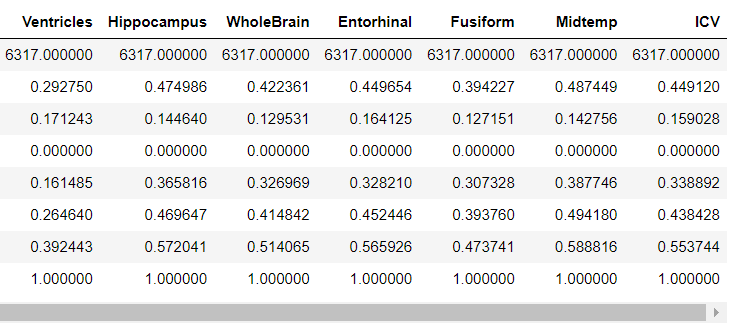

In [27]:
len(Y_test)

1576

#### v1.0
- The dataset is already prepared.
- It doesn't have any null values.
- It is normalized and all numeric. I can add two categorical features: Sex and Marital Status. Maybe later.

#### v1.1:
- HOWEVER: It is come to my realization that the scaling process done on MRI Data made the columns *such skewed* that they don't contribute to the score when training a logistic regression model.
- Thus, I will change the columns so that the skeweness (left skeweness in this case) will cease to exist or be milder.
- For that, I will try log transform and boxcox transform.
- But first lets do an anomaly detection, maybe problem comes from there

#### v1.2: 
- There were anomalies causing the skewness. 
- I took the raw data and analyzed it.
- After anomaly detection, it became better.

#### v1.3:
- I am given a new dataset. 9.1.2023, trying it.

In [28]:
# ICV column min value = 2.918840e+02. Must be an anomaly as min value in X_train is more reasonable, let's check it out!

#X_test_ICV = X_test['ICV']  # Creates a Series
#X_test_ICV = pd.DataFrame(X_test_ICV)  # Converts it to a dataframe
#sorted_ICV = X_test_ICV.sort_values(by = "ICV")
#sorted_ICV[0:15]

# As we can see, rows 834, 835 has extremely low value with respect to other values.
# I don't know if this row caused the problem in scaling the data, but I am deleting that data point.
# also deleting these 7.16*10**5 ones: 1349, 1350

In [29]:
#X_train_ICV = X_train['ICV']  # Creates a Series
#X_train_ICV = pd.DataFrame(X_train_ICV)  # Converts it to a dataframe
#sorted_ICV = X_train_ICV.sort_values(by = "ICV")
#sorted_ICV[0:25]

# let's delete row 210

In [30]:
# removing the rows from test set
#X_test = X_test.drop(labels=[834, 835, 1349, 1350], axis=0)
#Y_test = np.delete(Y_test, [834, 835, 1349, 1350], axis=0)
#X_test.describe()


In [31]:
len(X_test)

1576

In [32]:
# removing the rows from train set
#X_train = X_train.drop(labels=[210], axis=0)
#Y_train = np.delete(Y_train, [210], axis=0)
#X_train.describe()


### Scaling the Data
- https://surfer.nmr.mgh.harvard.edu/fswiki/eTIV 
- https://www.frontiersin.org/articles/10.3389/fnagi.2014.00264/full
- https://www.researchgate.net/publication/11787474_Normalization_of_cerebral_volumes_by_use_of_intracranial_volume_Implications_for_longitudinal_quantitative_MR_imaging
- We have to take ICV into account when scaling the MRI data as people have different brain sizes in the first place.


In [33]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
# A basic scaling is not suited well MRI data. Sources are above.
# But, I perform basic ICV normalization by dividing it.

In [34]:
# ICV normalizing the data: (It is already done in the new data!!!)
#X_train['Ventricles'] = X_train['Ventricles']/X_train['ICV']
#X_train['Hippocampus'] = X_train['Hippocampus']/X_train['ICV']
#X_train['WholeBrain'] = X_train['WholeBrain']/X_train['ICV']
#X_train['Entorhinal'] = X_train['Entorhinal']/X_train['ICV']
#X_train['Fusiform'] = X_train['Fusiform']/X_train['ICV']
#X_train['MidTemp'] = X_train['MidTemp']/X_train['ICV']

#X_test['Ventricles'] = X_test['Ventricles']/X_test['ICV']
##X_test['Hippocampus'] = X_test['Hippocampus']/X_test['ICV']
#X_test['WholeBrain'] = X_test['WholeBrain']/X_test['ICV']
#X_test['Entorhinal'] = X_test['Entorhinal']/X_test['ICV']
#X_test['Fusiform'] = X_test['Fusiform']/X_test['ICV']
#X_test['MidTemp'] = X_test['MidTemp']/X_test['ICV'] # Midtemp -> MidTemp

In [35]:
X_test.describe()

CDRSB       ADAS11       ADAS13         MMSE  RAVLT_immediate  \
count  1576.000000  1576.000000  1576.000000  1576.000000      1576.000000   
mean      0.176748     0.204816     0.255017     0.845749         0.395745   
std       0.180195     0.145127     0.151537     0.162273         0.164833   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.055556     0.104714     0.145059     0.800000         0.280000   
50%       0.111111     0.171429     0.223529     0.900000         0.386667   
75%       0.250000     0.257143     0.333294     0.966667         0.493333   
max       1.000000     0.985714     0.988235     1.000000         0.946667   

       RAVLT_learning  RAVLT_forgetting          FAQ   Ventricles  \
count     1576.000000       1576.000000  1576.000000  1576.000000   
mean         0.434878          0.637568     0.263917     0.307317   
std          0.132720          0.089732     0.292752     0.186849   
min          0.000000          0.307692     0.000000    -0.003154   
25%          0.315789          0.576923     0.033333     0.172750   
50%          0.421053          0.615385     0.133333     0.271294   
75%          0.526316          0.692308     0.433333     0.384459   
max          0.842105          1.038462     1.000000     0.971229   

       Hippocampus   WholeBrain   Entorhinal     Fusiform      MidTemp  
count  1576.000000  1576.000000  1576.000000  1576.000000  1576.000000  
mean      0.345867     0.220762     0.422766     0.296154     0.280691  
std       0.104315     0.079548     0.149109     0.102130     0.089115  
min       0.079977     0.013375     0.040887     0.035330     0.012162  
25%       0.269777     0.160654     0.321145     0.224344     0.218004  
50%       0.331476     0.217143     0.425263     0.291746     0.281549  
75%       0.414749     0.275625     0.517269     0.373948     0.336580  
max       0.990178     0.836676     1.169074     0.740754     0.628833

- As we can see, MRI data has changed.

In [36]:
# Let's put the data into a [0-1] interval. Scale it!
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# transforms dataframes to numpy, gotta convert back

In [37]:
# conversion. numpy to df
X_test = pd.DataFrame(X_test, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 
X_train = pd.DataFrame(X_train, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 

In [38]:
X_test.describe()

CDRSB       ADAS11       ADAS13         MMSE  RAVLT_immediate  \
count  1576.000000  1576.000000  1576.000000  1576.000000      1576.000000   
mean      0.176748     0.207785     0.258052     0.845749         0.418040   
std       0.180195     0.147230     0.153341     0.162273         0.174119   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.055556     0.106232     0.146786     0.800000         0.295775   
50%       0.111111     0.173913     0.226190     0.900000         0.408451   
75%       0.250000     0.260870     0.337262     0.966667         0.521127   
max       1.000000     1.000000     1.000000     1.000000         1.000000   

       RAVLT_learning  RAVLT_forgetting          FAQ   Ventricles  \
count     1576.000000       1576.000000  1576.000000  1576.000000   
mean         0.516418          0.451409     0.263917     0.318633   
std          0.157605          0.122791     0.292752     0.191761   
min          0.000000          0.000000     0.000000     0.000000   
25%          0.375000          0.368421     0.033333     0.180528   
50%          0.500000          0.421053     0.133333     0.281663   
75%          0.625000          0.526316     0.433333     0.397803   
max          1.000000          1.000000     1.000000     1.000000   

       Hippocampus   WholeBrain   Entorhinal     Fusiform      MidTemp  
count  1576.000000  1576.000000  1576.000000  1576.000000  1576.000000  
mean      0.292122     0.251897     0.338490     0.369741     0.435449  
std       0.114606     0.096620     0.132167     0.144778     0.144509  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.208525     0.178888     0.248415     0.267943     0.333796  
50%       0.276311     0.247500     0.340703     0.363492     0.436841  
75%       0.367799     0.318534     0.422255     0.480021     0.526079  
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [39]:
X_train.describe()

CDRSB       ADAS11       ADAS13         MMSE  RAVLT_immediate  \
count  6318.000000  6318.000000  6318.000000  6318.000000      6318.000000   
mean      0.170439     0.202654     0.256359     0.845885         0.396585   
std       0.159561     0.134582     0.145732     0.148238         0.165549   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.055556     0.109571     0.152941     0.766667         0.280000   
50%       0.111111     0.171429     0.235294     0.866667         0.373333   
75%       0.250000     0.265500     0.341176     0.966667         0.493333   
max       1.000000     1.000000     1.000000     1.000000         1.000000   

       RAVLT_learning  RAVLT_forgetting          FAQ   Ventricles  \
count     6318.000000       6318.000000  6318.000000  6318.000000   
mean         0.435806          0.634603     0.264092     0.292800   
std          0.140703          0.089518     0.280941     0.171274   
min          0.000000          0.000000     0.000000     0.000000   
25%          0.315789          0.576923     0.033333     0.161485   
50%          0.421053          0.653846     0.166667     0.264660   
75%          0.526316          0.692308     0.433333     0.392443   
max          1.000000          1.000000     1.000000     1.000000   

       Hippocampus   WholeBrain   Entorhinal     Fusiform      MidTemp  
count  6318.000000  6318.000000  6318.000000  6318.000000  6318.000000  
mean      0.347771     0.221399     0.430837     0.289734     0.276103  
std       0.106179     0.068560     0.157374     0.093832     0.081332  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.267769     0.171300     0.314470     0.225787     0.219538  
50%       0.343771     0.217362     0.433422     0.289282     0.279851  
75%       0.418708     0.269322     0.542138     0.348226     0.333396  
max       1.000000     1.000000     1.000000     1.000000     1.000000

#### My "old" comments on column statistics

- CDRSB, ADASI1, ADASI3, MMSE, FAQ, Ventricles columns' distributions are skewed. Not like a normal distribution.
- in some MRI data columns, from the quantiles and mean statistic, we can deduce that, train and test data distributions are not the same for those columns.
- For now we don't need log transform etc. Let's get to the modeling.

In [40]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('Y_train.npy', Y_train)
np.save('Y_test.npy', Y_test)

# Save the dataset

#### 1. Log-Transform trial (No need I guess, for now, ignore)

In [41]:
# log_distr_x_train = np.log(X_train + 10**-10)

In [42]:
# boxcox
#from scipy import stats
#from sklearn.preprocessing import MinMaxScaler

### Fit a linear logistic regression model

In [43]:
Y_test_describe = pd.DataFrame(Y_test)
Y_train_describe = pd.DataFrame(Y_train)

In [44]:
Y_test_describe.value_counts()
# mci=2, ad=3, mci-ad=5

2    1034
3     444
5      98
dtype: int64

In [45]:
Y_train_describe.value_counts()
# mci=2, ad=3, mci-ad=5

2    4101
3    1865
5     352
dtype: int64

In [46]:
# Save the multi label data.
Y_test_multi_saved = np.copy(Y_test)


Y_train_multi_saved = np.copy(Y_train)

In [47]:
Y_test_multi_saved[2]

3

In [48]:
Y_test_multi_1 = np.copy(Y_test)
Y_train_multi_1 = np.copy(Y_train)
Y_test_multi_2 = np.copy(Y_test)
Y_train_multi_2 = np.copy(Y_train)
X_test_multi_1 = np.copy(X_test)
X_train_multi_1 = np.copy(X_train)
X_test_multi_2 = np.copy(X_test)
X_train_multi_2 = np.copy(X_train)
# data is copied into 2 sets that will be used later.

In [49]:
#Y_test_multi_1 = np.delete(Y_test_multi_1, np.where(    Y_test_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

##Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

#Y_train_multi_1 = np.delete(Y_train_multi_1, np.where(    Y_train_multi_1 == 5)[0], axis=0)

- We can see that data is unbalanced.

In [50]:
#Y_train = np.delete(Y_train, np.where(Y_train == 5)[0], axis=0)

#Y_test = np.delete(Y_test, np.where(Y_test == 5)[0], axis=0)

# Deleting mci-ad label from this set. To work with binary labels only.

In [51]:
filtered_train = Y_train != 5
filtered_test = Y_test != 5

X_train = X_train[filtered_train]

X_test = X_test[filtered_test]

In [52]:
Y_train = Y_train[filtered_train]

Y_test = Y_test[filtered_test]

In [59]:
len(Y_test)

1478

In [60]:
X_test.describe()

CDRSB       ADAS11       ADAS13         MMSE  RAVLT_immediate  \
count  1478.000000  1478.000000  1478.000000  1478.000000      1478.000000   
mean      0.171685     0.203931     0.252876     0.850586         0.426023   
std       0.182658     0.148844     0.154722     0.163688         0.174723   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.055556     0.101449     0.142857     0.800000         0.309859   
50%       0.111111     0.159420     0.214286     0.900000         0.422535   
75%       0.222222     0.260870     0.329405     0.966667         0.521127   
max       1.000000     1.000000     1.000000     1.000000         1.000000   

       RAVLT_learning  RAVLT_forgetting          FAQ   Ventricles  \
count     1478.000000       1478.000000  1478.000000  1478.000000   
mean         0.521313          0.452105     0.252210     0.314842   
std          0.158493          0.123857     0.293375     0.191390   
min          0.125000          0.000000     0.000000     0.000000   
25%          0.375000          0.368421     0.033333     0.178191   
50%          0.500000          0.473684     0.133333     0.278466   
75%          0.625000          0.526316     0.400000     0.393292   
max          1.000000          1.000000     1.000000     1.000000   

       Hippocampus   WholeBrain   Entorhinal     Fusiform      MidTemp  
count  1478.000000  1478.000000  1478.000000  1478.000000  1478.000000  
mean      0.295734     0.254918     0.342739     0.374514     0.440455  
std       0.115658     0.096872     0.131806     0.144501     0.144464  
min       0.000000     0.000000     0.005324     0.000000     0.000000  
25%       0.209831     0.183468     0.253132     0.273425     0.342376  
50%       0.280841     0.251488     0.346233     0.367107     0.443148  
75%       0.371836     0.322671     0.429547     0.485605     0.529113  
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [61]:
# Adjusting to binary classification:

Y_train[Y_train == 2] = 0 # mci
Y_train[Y_train == 3] = 1 # ad

Y_test[Y_test == 2] = 0
Y_test[Y_test == 3] = 1


In [62]:
Y_test_describe = pd.DataFrame(Y_test)
Y_train_describe = pd.DataFrame(Y_train)

In [63]:
Y_test_describe.value_counts()

0    1034
1     444
dtype: int64

In [64]:
Y_train_describe.value_counts()

0    4101
1    1865
dtype: int64

In [65]:
#X_test = X_test.drop(columns=['ICV', 'APOE4'])
#X_train = X_train.drop(columns=['ICV', 'APOE4'])
# We don't need the ICV now. APOE4 is not used either.

<AxesSubplot:>

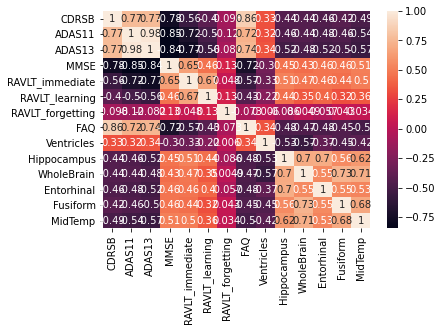

In [66]:
# Correlation visualisation.
#sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X_train.corr(), annot=True)


#### Comments on correlation map:

- There are strong negative and positive correlations between some of the features.
- CDRSB, ADAS11, ADAS13, MMSE, FAQ are emphasized.

In [67]:
X_train = X_train.drop(['ADAS11'], axis=1)
X_test = X_test.drop(['ADAS11'], axis=1)
# Since ADAS11 and ADAS13 are highly correlated, drop 1.
# It didn't increase the accuracy. Changed the shap values slightly.

In [68]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")

In [69]:
logmodel.fit(X_train, Y_train)

LogisticRegression(max_iter=2000, penalty='l1', solver='saga', tol=0.001)

In [70]:
predictions = logmodel.predict(X_test)

In [71]:
predictions.sum()

402

In [72]:
score = logmodel.score(X_test,Y_test)
score

0.9553450608930988

### Statistics regarding the predictions

In [60]:
precision_recall_fscore_support(Y_test, predictions)
# Return value may look cryptic.
# Precision: 0.97014925
# Recall   : 0.87837838

(array([0.94981413, 0.97014925]),
 array([0.98839458, 0.87837838]),
 array([0.96872038, 0.92198582]),
 array([1034,  444], dtype=int64))

In [61]:
cm = confusion_matrix(Y_test, predictions)

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

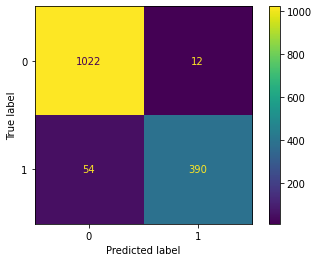

In [63]:
disp.plot()

In [64]:
np.exp(np.abs(logmodel.coef_))

array([[1.1183211e+05, 3.6551594e+01, 2.6980107e+03, 2.1040039e+00,
        4.2580619e+00, 1.4075854e+00, 2.3758867e+01, 2.6206460e+00,
        1.0000290e+00, 2.2686827e+00, 3.6711507e+00, 2.1567376e+00,
        1.0000000e+00]], dtype=float32)

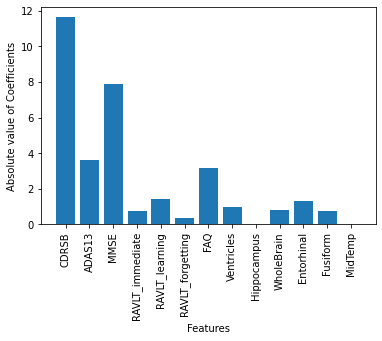

In [65]:
# Normally, should get the exp of coefficients. But they become too big.
coef = np.abs(logmodel.coef_)

# Plot the vector
plt.bar(range(len(coef[0])), coef[0])
plt.xlabel("Features")
plt.ylabel("Absolute value of Coefficients")

# Get the names of the features
feature_names = X_train.columns

# Set the names of the features as the x-axis tick labels
plt.xticks(range(len(coef[0])), feature_names, rotation=90)
plt.show()

# 'CDRSB', 'ADAS13', 'MMSE', 'FAQ': 
# these are the most important ones according to Logistic regression model's coef's.

### Explain the model and features using SHAP
 https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html
 
https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer

In [66]:
# sns.set(rc = {'figure.figsize':(15,8)}) to create square boxes in the background.
explainer = shap.Explainer(logmodel, X_train)
shap_values = explainer(X_test)
# The Explainer class is used to compute the SHAP values,
# it takes as input the model and the background dataset(X_train).
# Then, the shap values can be computed using the explainer(X_test) function.

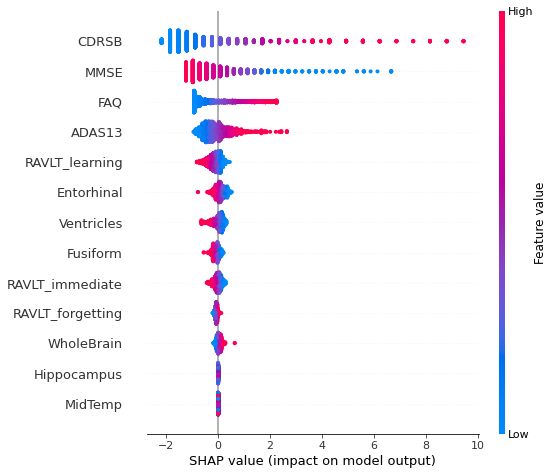

In [67]:
shap.summary_plot(shap_values, X_test)
# Rank of importance is pretty much similar to the logistic regression coefficient analysis.

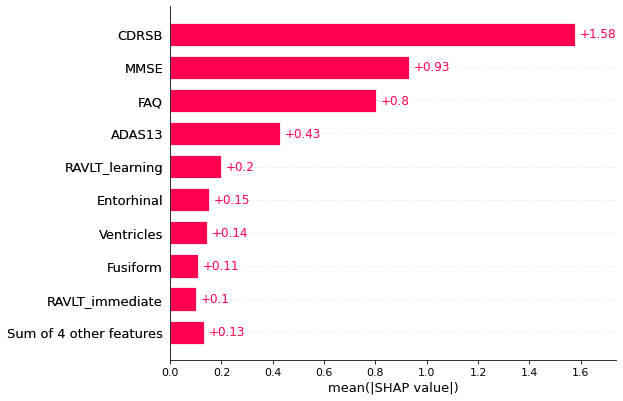

In [68]:
shap.plots.bar(shap_values) # mean absolute value for each feature column as a bar chart

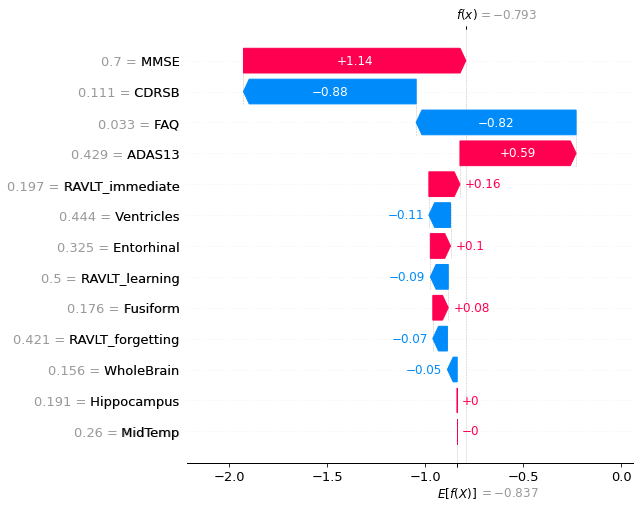

In [69]:
shap.waterfall_plot(shap_values[74], max_display=14)

Cohort-bar-plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html

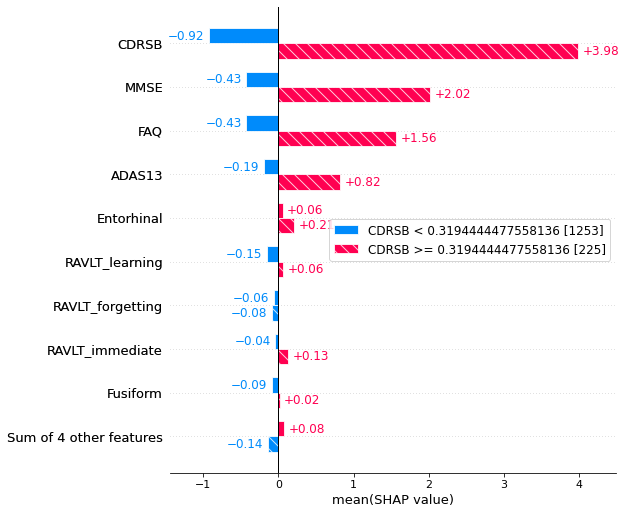

In [70]:
shap.plots.bar(shap_values.cohorts(2).mean(0))

Simple-dependence-scatter-plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html#Simple-dependence-scatter-plot

invalid value encountered in divide
invalid value encountered in divide


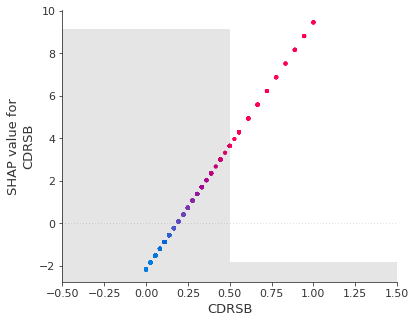

In [71]:
shap.plots.scatter(shap_values[:,"CDRSB"],color=shap_values)

Using feature clustering: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html#Using-feature-clustering

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


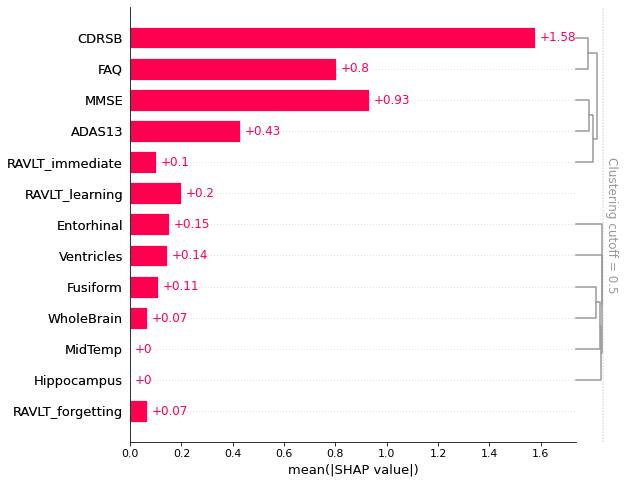

In [72]:
clustering = shap.utils.hclust(X_test, Y_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values, clustering=clustering, max_display=14) # , cluster_threshold can be 0.3 etc. but error.

In [73]:
shap.plots.force(shap_values)

In [74]:
shap.initjs()

In [75]:
ind = 5
shap.plots.force(shap_values[ind])

- Base value = -0.8367. Shapley value for the index 5 is -4.12. It will be predicted as 0. **I assume**
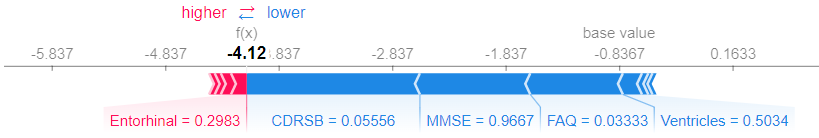

My assumption is wrong.
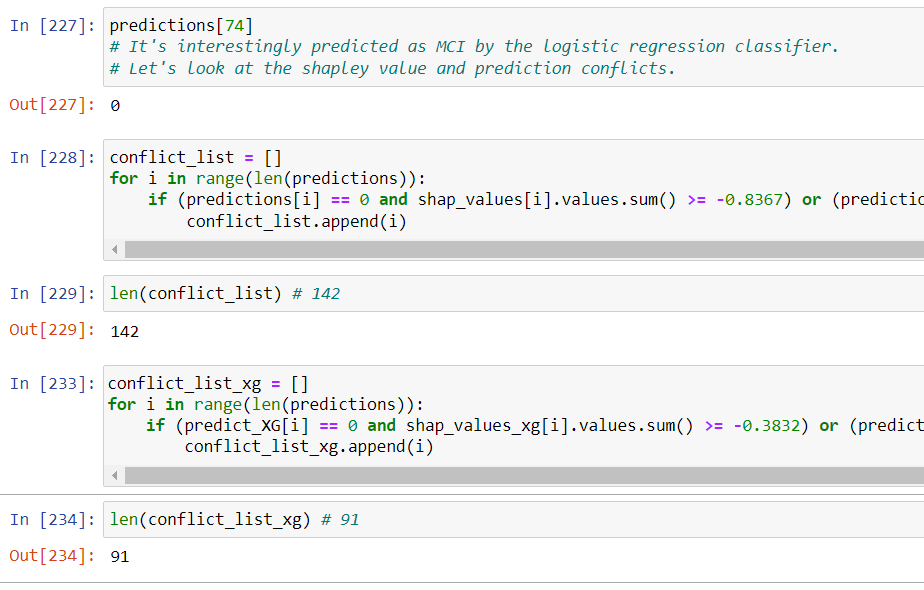

In [76]:
predictions[5]

0

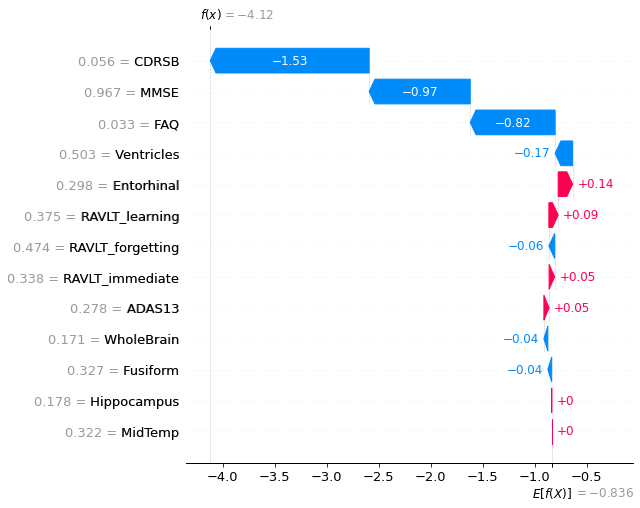

In [77]:
shap.waterfall_plot(shap_values[5], max_display=14)

In [76]:
ind = 77
shap.plots.force(shap_values[ind])
# 7.71 > -0.8393    => prediction[77] would be 1.

In [77]:
predictions[77]

1

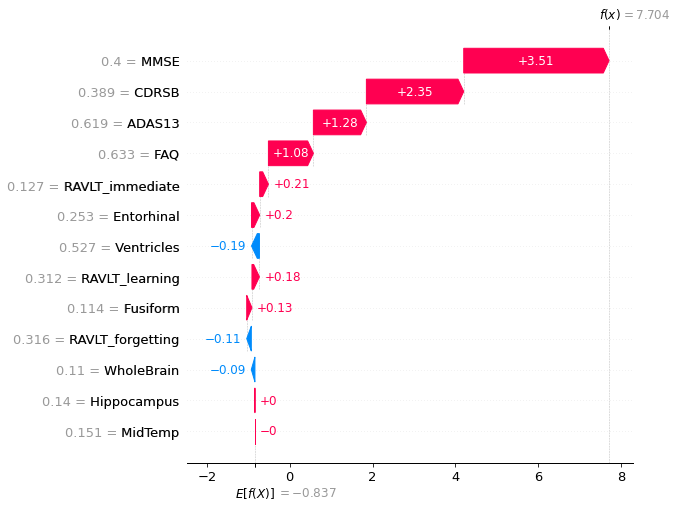

In [78]:
shap.waterfall_plot(shap_values[77], max_display=14)
# different version of individual shap value visualization.
# The interpretation of the Shapley value for feature value j is:
# The value of the j-th feature contributed ϕ_j to the prediction of this particular instance
# compared to the average prediction for the dataset.

In [79]:
X_test.take([77]) # shap_values[77].data gives these numbers
# which we can also see in the waterfall plot

CDRSB    ADAS13  MMSE  RAVLT_immediate  RAVLT_learning  \
84  0.388889  0.619048   0.4         0.126761          0.3125   

    RAVLT_forgetting       FAQ  Ventricles  Hippocampus  WholeBrain  \
84          0.315789  0.633333     0.52693     0.140399    0.110252   

    Entorhinal  Fusiform  MidTemp  
84    0.253348  0.114489  0.15077

In [80]:
shap_values[77]
# 'CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate',
# 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles',
# 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
# 'MidTemp'

.values =
array([ 2.3475549e+00,  1.2782818e+00,  3.5050881e+00,  2.1098305e-01,
        1.8014856e-01, -1.1057674e-01,  1.0844971e+00, -1.9065154e-01,
        5.7131033e-06, -8.7252311e-02,  1.9669552e-01,  1.2624592e-01,
       -0.0000000e+00], dtype=float32)

.base_values =
-0.83661413

.data =
array([0.3888889 , 0.61904764, 0.40000004, 0.12676056, 0.3125    ,
       0.31578946, 0.6333334 , 0.5269303 , 0.14039892, 0.11025216,
       0.25334755, 0.11448905, 0.1507704 ], dtype=float32)

In [81]:
trial_value = 0.18
range_list = []
for i in range(len(shap_values)):
    
    CDRSB_value_i = shap_values[i].data[0] # i_th data CDRSB column value.
    if abs(trial_value - CDRSB_value_i) < 0.041:
        range_list.append((i,CDRSB_value_i, shap_values[i].values[0],predictions[i]))

In [82]:
range_list

[(0, 0.19444445, 0.08718609, 1),
 (31, 0.16666667, -0.23572372, 0),
 (37, 0.19444445, 0.08718609, 0),
 (47, 0.19444445, 0.08718609, 1),
 (81, 0.16666667, -0.23572372, 0),
 (101, 0.16666667, -0.23572372, 0),
 (103, 0.16666667, -0.23572372, 0),
 (116, 0.16666667, -0.23572372, 0),
 (135, 0.19444445, 0.08718609, 0),
 (136, 0.19444445, 0.08718609, 0),
 (158, 0.19444445, 0.08718609, 0),
 (159, 0.19444445, 0.08718609, 0),
 (171, 0.16666667, -0.23572372, 0),
 (176, 0.16666667, -0.23572372, 0),
 (177, 0.16666667, -0.23572372, 0),
 (182, 0.16666667, -0.23572372, 0),
 (189, 0.16666667, -0.23572372, 0),
 (190, 0.19444445, 0.08718609, 0),
 (206, 0.16666667, -0.23572372, 0),
 (207, 0.16666667, -0.23572372, 0),
 (208, 0.19444445, 0.08718609, 1),
 (209, 0.19444445, 0.08718609, 1),
 (213, 0.16666667, -0.23572372, 0),
 (223, 0.16666667, -0.23572372, 0),
 (224, 0.16666667, -0.23572372, 0),
 (225, 0.19444445, 0.08718609, 0),
 (228, 0.16666667, -0.23572372, 0),
 (229, 0.16666667, -0.23572372, 0),
 (230, 0.

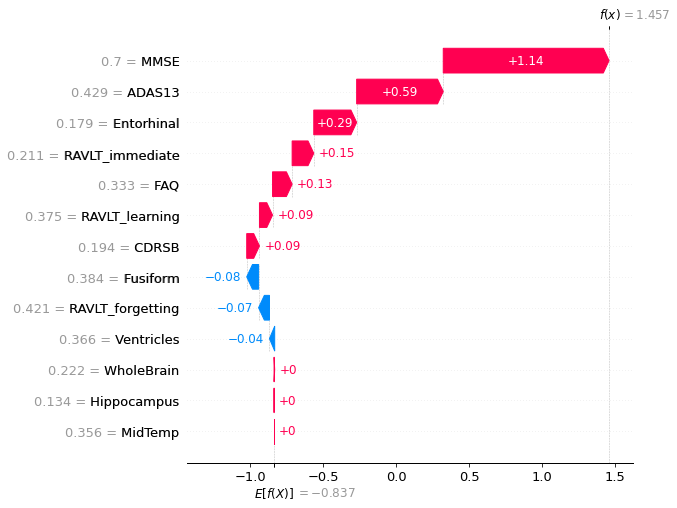

In [83]:
shap.waterfall_plot(shap_values[0], max_display=14)

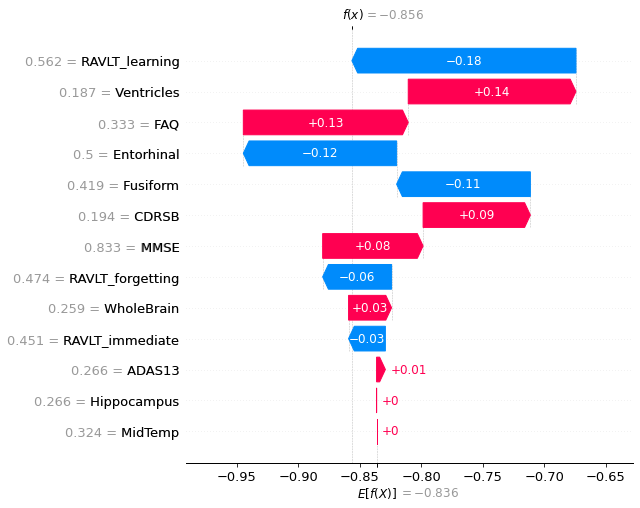

In [86]:
shap.waterfall_plot(shap_values[37], max_display=14)

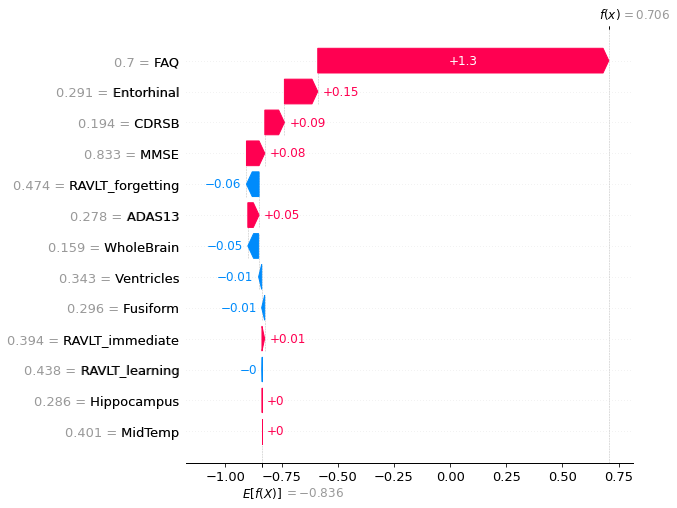

In [87]:
shap.waterfall_plot(shap_values[47], max_display=14)

In [88]:
shap_values[76]

.values =
array([ 2.3481827e+00,  1.2776588e+00,  3.5058517e+00,  2.1062510e-01,
        1.8024497e-01, -1.0946259e-01,  1.0842240e+00, -1.9050163e-01,
        7.3996894e-06, -8.8098913e-02,  1.9675355e-01,  1.2699820e-01,
       -0.0000000e+00], dtype=float32)

.base_values =
-0.8363013

.data =
array([0.3888889 , 0.61904764, 0.40000004, 0.12676056, 0.3125    ,
       0.31578946, 0.6333334 , 0.5269303 , 0.14039892, 0.11025216,
       0.25334755, 0.11448905, 0.1507704 ], dtype=float32)

In [89]:
shap_values[1434]

.values =
array([ 2.3481827e+00,  8.9226907e-01,  1.9254537e+00,  1.1649523e-01,
        8.9645587e-02, -7.3838264e-02,  1.5065118e+00,  1.4112487e-01,
        3.4643413e-06,  6.9542520e-02,  1.3458486e-01, -1.3757269e-01,
        0.0000000e+00], dtype=float32)

.base_values =
-0.8363013

.data =
array([0.3888889 , 0.5119048 , 0.6       , 0.2535211 , 0.37500003,
       0.42105263, 0.7666667 , 0.18244171, 0.2455109 , 0.30083647,
       0.30113694, 0.4566759 , 0.40401337], dtype=float32)

In [90]:
shap_values[77].values.sum() + shap_values[77].base_values 
# this gives the shapley value for individual: index = 77

7.706183

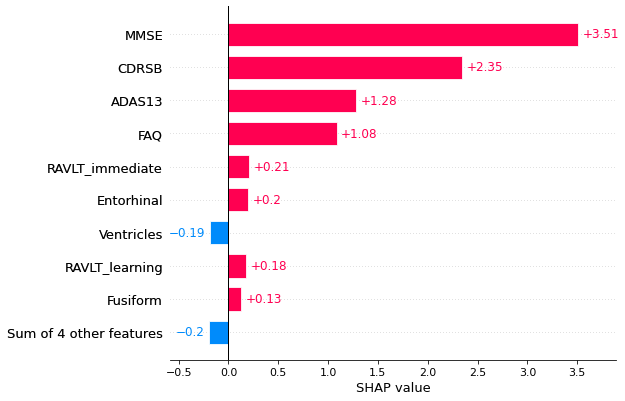

In [91]:
shap.plots.bar(shap_values[77])
# individual shap values
# bar plot of the data in above cell.

#### Look at the Shapley Values for MCI and AD patients seperately

In [96]:
shap_values_mci = shap_values[Y_test == 0]
shap_values_ad = shap_values[Y_test == 1]
# look at how the importance of different features differs between MCI and AD patients

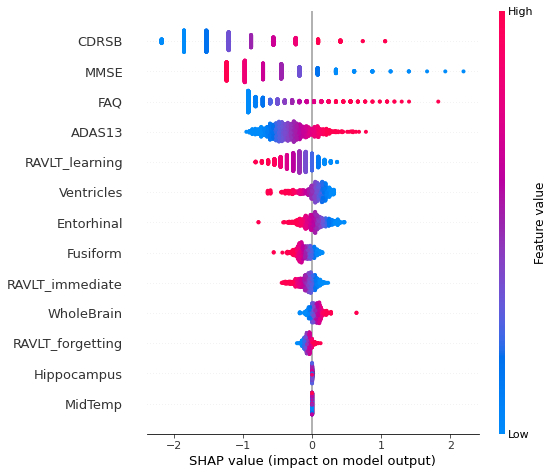

In [97]:
shap.summary_plot(shap_values_mci)

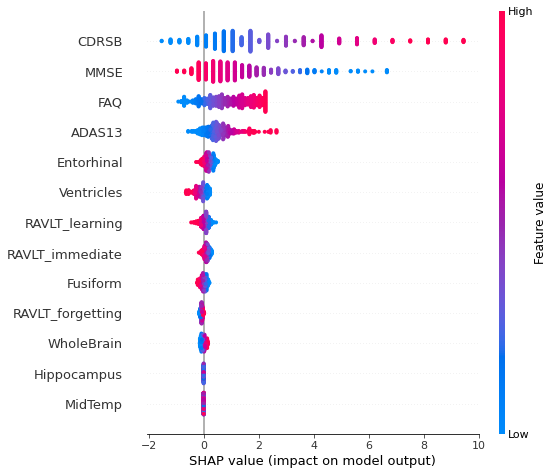

In [98]:
shap.summary_plot(shap_values_ad)

- MCI patients' shapley values are lower than AD
- The reason why is that when shapley value of a datapoint is below -0.83 it is predicted as an MCI patient.
- That's why CDRSB is on the left a lot, or the average sum of the feature shapley values are left oriented. (-0.83)

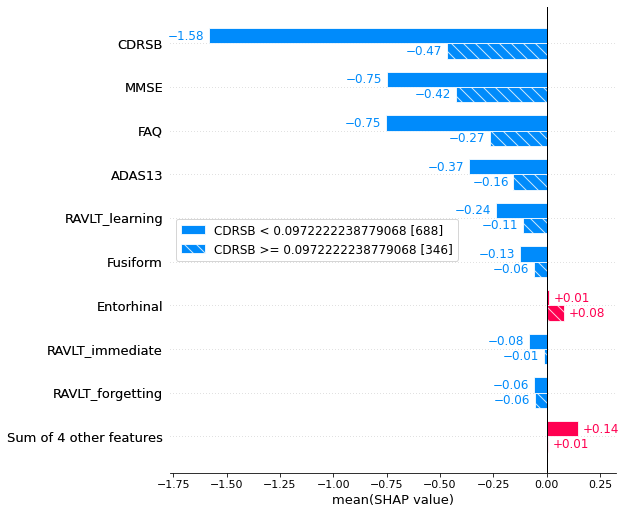

In [94]:
shap.plots.bar(shap_values_mci.cohorts(2).mean(0))
# 0.0972222238779068

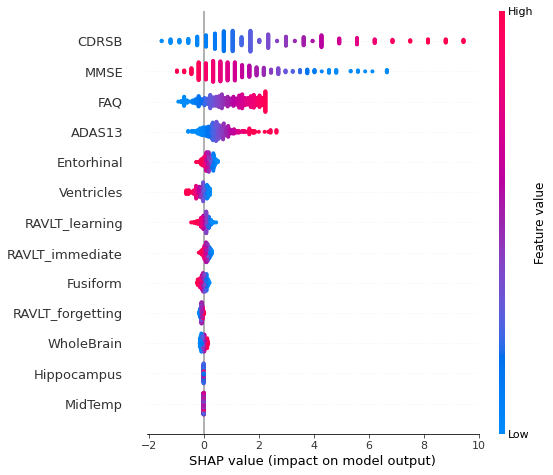

In [95]:
shap.summary_plot(shap_values_ad)

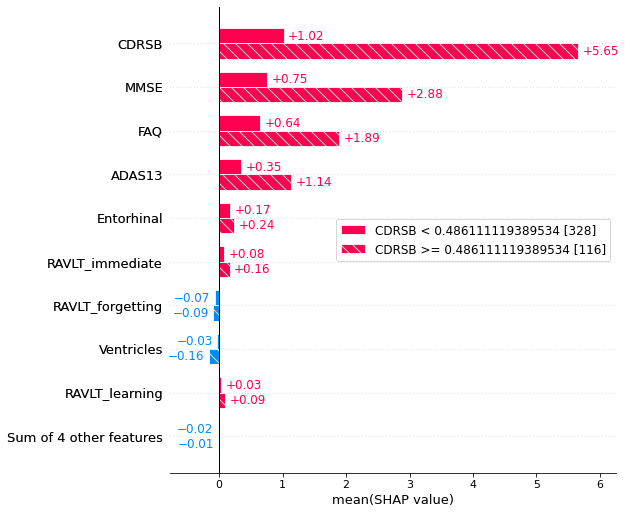

In [96]:
shap.plots.bar(shap_values_ad.cohorts(2).mean(0))

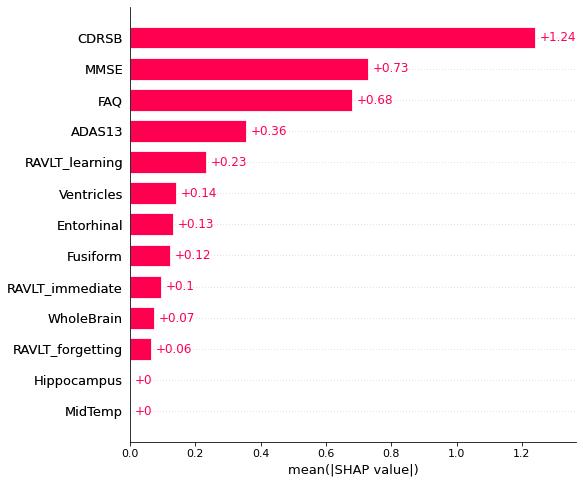

In [97]:
shap.plots.bar(shap_values_mci,max_display=14) # mean absolute value for each feature column as a bar chart

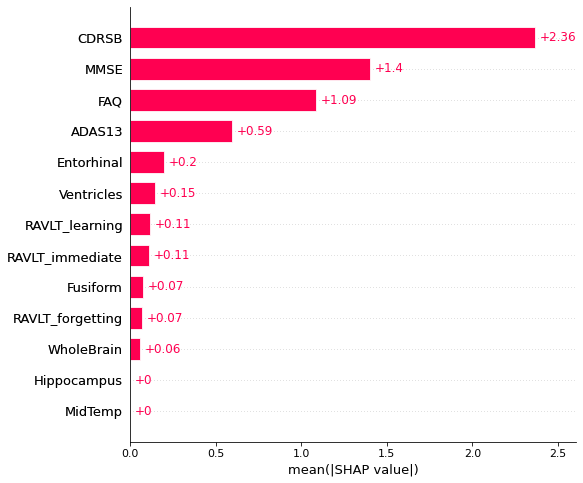

In [98]:
shap.plots.bar(shap_values_ad, max_display=14) 

### Comments on MCI vs AD Shapley Values

- MCI patients' shapley values are lower than AD
- The reason why is that the total value of these??? 

In [91]:
# Let's look at our features if they are linearly separable.
from sklearn.manifold import TSNE

In [92]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=250)
tsne_results = tsne.fit_transform(X_train)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5966 samples in 0.017s...
[t-SNE] Computed neighbors for 5966 samples in 0.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5966
[t-SNE] Computed conditional probabilities for sample 2000 / 5966
[t-SNE] Computed conditional probabilities for sample 3000 / 5966
[t-SNE] Computed conditional probabilities for sample 4000 / 5966
[t-SNE] Computed conditional probabilities for sample 5000 / 5966
[t-SNE] Computed conditional probabilities for sample 5966 / 5966
[t-SNE] Mean sigma: 0.128651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.764198
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.0

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

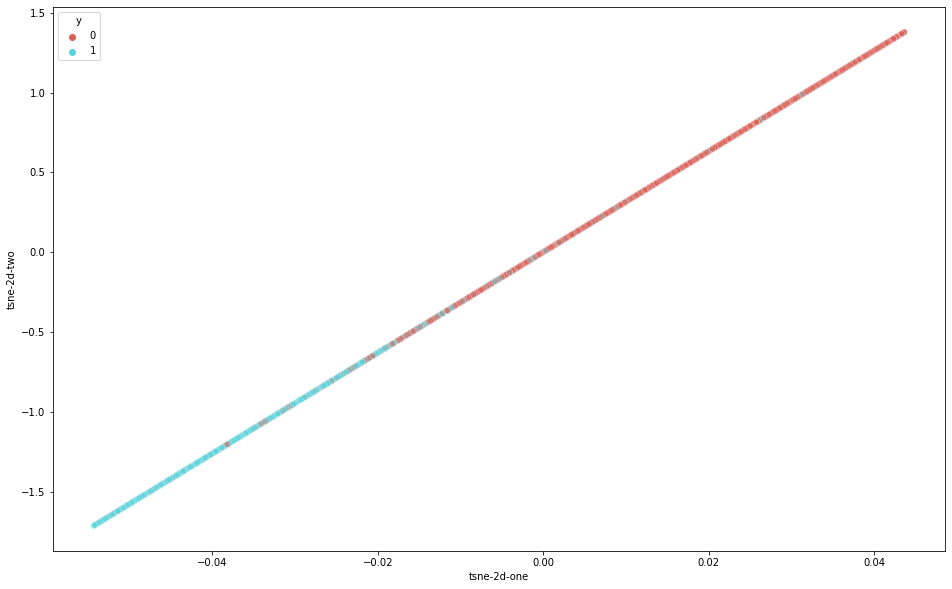

In [93]:
df_subset = {}
df_subset['y'] = Y_train
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue = "y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

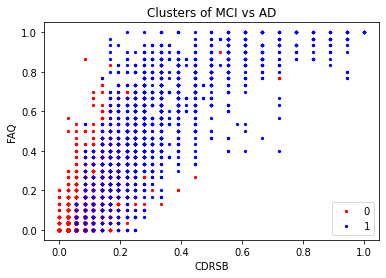

In [260]:

# Get the 2 first features from the DataFrame, this is assuming that you want to plot 2D clusters
X_train_2D = X_train[['CDRSB','FAQ']]
X_test_2D = X_test[['CDRSB','FAQ']]

# Concatenate the train and test set
X_2D = pd.concat([X_train_2D, X_test_2D])
y = np.concatenate([Y_train, Y_test])

# Plot the clusters with different colors
for i in range(2):
    # Get the index of elements with label i
    idx = (y == i)
    plt.scatter(X_2D.iloc[idx, 0], X_2D.iloc[idx, 1], c=['r' if i == 0 else 'b'], label=i, s=5)
plt.legend()

plt.xlabel('CDRSB')
plt.ylabel('FAQ')

plt.title('Clusters of MCI vs AD')
plt.show()

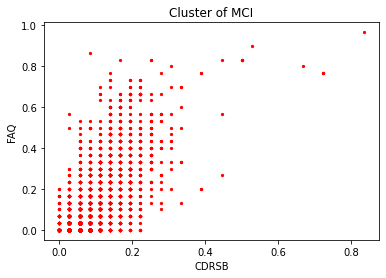

In [263]:
# Get the index of elements with label 0
idx = (y == 0)

# Plot the elements with label 0
plt.scatter(X_2D.iloc[idx, 0], X_2D.iloc[idx, 1], c='r', label=0, s=5)
plt.xlabel('CDRSB')
plt.ylabel('FAQ')

plt.title('Cluster of MCI')
plt.show()

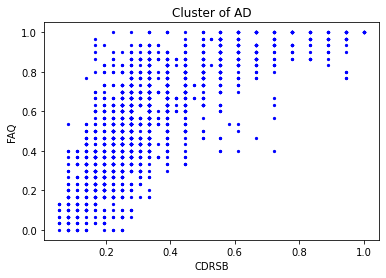

In [264]:
# Get the index of elements with label 0
idx = (y == 1)

# Plot the elements with label 0
plt.scatter(X_2D.iloc[idx, 0], X_2D.iloc[idx, 1], c='b', label=0, s=5)
plt.xlabel('CDRSB')
plt.ylabel('FAQ')

plt.title('Cluster of AD')
plt.show()

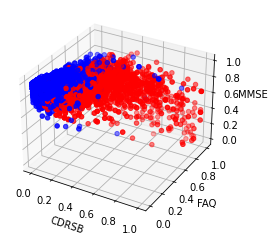

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Select 3 features
# X_3d = X_test[['CDRSB','FAQ', 'MMSE']]
X_train_3D = X_train[['CDRSB','FAQ', 'MMSE']]
X_test_3D = X_test[['CDRSB','FAQ', 'MMSE']]

# Concatenate the train and test set
X_3D = pd.concat([X_train_3D, X_test_3D])
y = np.concatenate([Y_train, Y_test])

# Assign color to each label
colors = ['blue' if label == 0 else 'red' for label in y]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D['CDRSB'], X_3D['FAQ'], X_3D['MMSE'], c=colors)

# Set the labels for the x, y, and z axes
ax.set_xlabel('CDRSB')
ax.set_ylabel('FAQ')
ax.set_zlabel('MMSE')

plt.show()

- for low FAQ, high MMSE, low CDRSB patient is MCI
- for high FAQ, low MMSE, high CDRSB patient is AD
- features are somewhat correlated and data is somewhat linearly separable, that's why logistic regression works smoothly.

- MCI vs MCI-AD

In [95]:
#X_test_multi_1 = np.copy(X_test)
#X_train_multi_1 = np.copy(X_train)
#Y_test_multi_1 = np.copy(Y_test)
#Y_train_multi_1 = np.copy(Y_train)

filtered_train_multi = Y_train_multi_1 != 3
filtered_test_multi = Y_test_multi_1 != 3

X_train_multi_1 = X_train_multi_1[filtered_train_multi]

X_test_multi_1 = X_test_multi_1[filtered_test_multi]


Y_train_multi_1 = Y_train_multi_1[filtered_train_multi]

Y_test_multi_1 = Y_test_multi_1[filtered_test_multi]

In [96]:
# Adjusting to binary classification:

Y_train_multi_1[Y_train_multi_1 == 2] = 0 # mci
Y_train_multi_1[Y_train_multi_1 == 5] = 1 # mci-ad

Y_test_multi_1[Y_test_multi_1 == 2] = 0
Y_test_multi_1[Y_test_multi_1 == 5] = 1

In [103]:
# conversion. numpy to df
X_test_multi_1 = pd.DataFrame(X_test_multi_1, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 
X_train_multi_1 = pd.DataFrame(X_train_multi_1, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 

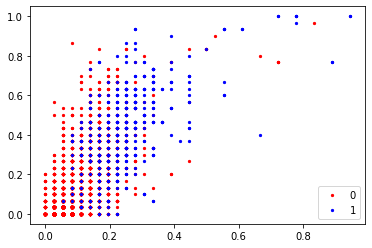

In [109]:

# Get the 2 first features from the DataFrame, this is assuming that you want to plot 2D clusters
X_train_2D_multi = X_train_multi_1[['CDRSB','FAQ']]
X_test_2D_multi = X_test_multi_1[['CDRSB','FAQ']]

# Concatenate the train and test set
X_2D_multi = pd.concat([X_train_2D_multi, X_test_2D_multi])
y_multi = np.concatenate([Y_train_multi_1, Y_test_multi_1])

# Plot the clusters with different colors
for i in range(2):
    # Get the index of elements with label i
    idx = (y_multi == i)
    plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c=['r' if i == 0 else 'b'], label=i, s=5)
plt.legend()
plt.show()

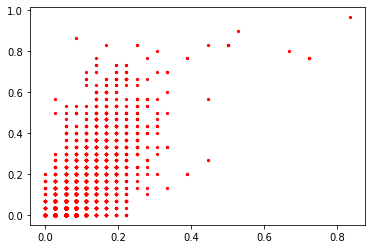

In [106]:
# Get the index of elements with label 0
idx = (y_multi == 0)

# Plot the elements with label 0
plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c='r', label=0, s=5)


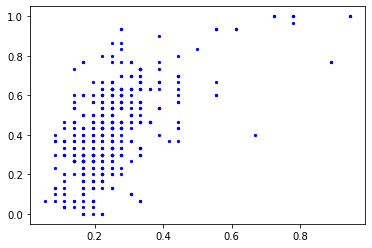

In [107]:
# Get the index of elements with label 0
idx = (y_multi == 1)

# Plot the elements with label 0
plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c='b', label=0, s=5)


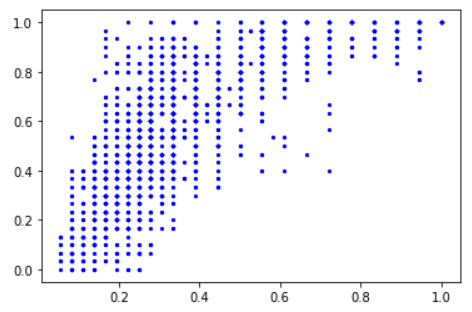

In [153]:
logmodel_multi = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel_multi.fit(X_train_multi_1, Y_train_multi_1)
predictions_multi = logmodel_multi.predict(X_test_multi_1)
score_multi = logmodel_multi.score(X_test_multi_1,Y_test_multi_1)
score_multi


0.946113074204947

In [154]:
precision_recall_fscore_support(Y_test_multi_1, predictions_multi)

(array([0.94429224, 1.        ]),
 array([1.        , 0.37755102]),
 array([0.97134805, 0.54814815]),
 array([1034,   98], dtype=int64))

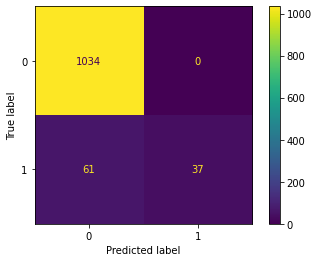

In [155]:
cm_multi = confusion_matrix(Y_test_multi_1, predictions_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi)
disp_multi.plot()
# finding mci-ad patients is difficult as the data is unbalanced.

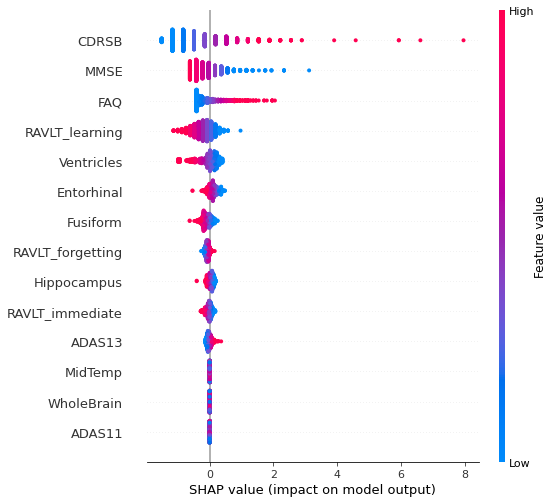

In [156]:
explainer_multi = shap.Explainer(logmodel_multi, X_train_multi_1)
shap_values_multi = explainer_multi(X_test_multi_1)
shap.summary_plot(shap_values_multi, X_test_multi_1)
# At least the shap values are similar to the mci vs ad case.

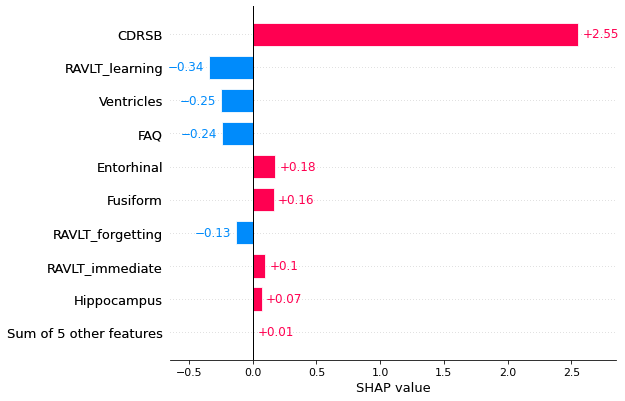

In [157]:
shap.plots.bar(shap_values_multi[77])

In [158]:
predictions_multi[77]

0

- MCI-AD vs AD

In [114]:
#X_test_multi_1 = np.copy(X_test)
#X_train_multi_1 = np.copy(X_train)
#Y_test_multi_1 = np.copy(Y_test)
#Y_train_multi_1 = np.copy(Y_train)

filtered_train_multi = Y_train_multi_2 != 2
filtered_test_multi = Y_test_multi_2 != 2

X_train_multi_2 = X_train_multi_2[filtered_train_multi]

X_test_multi_2 = X_test_multi_2[filtered_test_multi]


Y_train_multi_2 = Y_train_multi_2[filtered_train_multi]

Y_test_multi_2 = Y_test_multi_2[filtered_test_multi]

In [123]:
# Adjusting to binary classification:

Y_train_multi_2[Y_train_multi_2 == 3] = 0 # ad
Y_train_multi_2[Y_train_multi_2 == 5] = 1 # mci-ad

Y_test_multi_2[Y_test_multi_2 == 3] = 0
Y_test_multi_2[Y_test_multi_2 == 5] = 1

In [124]:
# conversion. numpy to df
X_test_multi_2 = pd.DataFrame(X_test_multi_2, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 
X_train_multi_2 = pd.DataFrame(X_train_multi_2, columns = ['CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']) 

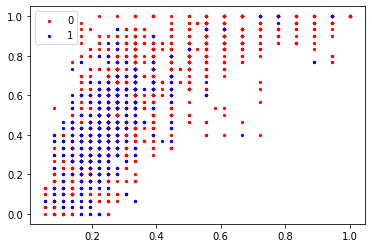

In [125]:

# Get the 2 first features from the DataFrame, this is assuming that you want to plot 2D clusters
X_train_2D_multi = X_train_multi_2[['CDRSB','FAQ']]
X_test_2D_multi = X_test_multi_2[['CDRSB','FAQ']]

# Concatenate the train and test set
X_2D_multi = pd.concat([X_train_2D_multi, X_test_2D_multi])
y_multi = np.concatenate([Y_train_multi_2, Y_test_multi_2])

# Plot the clusters with different colors
for i in range(2):
    # Get the index of elements with label i
    idx = (y_multi == i)
    plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c=['r' if i == 0 else 'b'], label=i, s=5)
plt.legend()
plt.show()

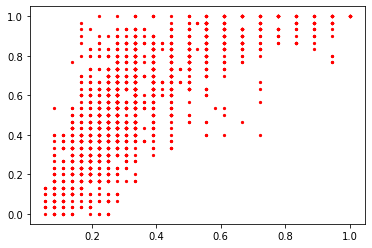

In [126]:
# Get the index of elements with label 0
idx = (y_multi == 0)

# Plot the elements with label 0
plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c='r', label=0, s=5)


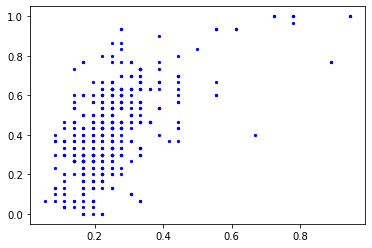

In [127]:
# Get the index of elements with label 0
idx = (y_multi == 1)

# Plot the elements with label 0
plt.scatter(X_2D_multi.iloc[idx, 0], X_2D_multi.iloc[idx, 1], c='b', label=0, s=5)


In [128]:
logmodel_multi = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel_multi.fit(X_train_multi_2, Y_train_multi_2)
predictions_multi = logmodel_multi.predict(X_test_multi_2)
score_multi = logmodel_multi.score(X_test_multi_2,Y_test_multi_2)
score_multi


0.8191881918819188

In [129]:
precision_recall_fscore_support(Y_test_multi_2, predictions_multi)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


(array([0.81918819, 0.        ]),
 array([1., 0.]),
 array([0.90060852, 0.        ]),
 array([444,  98], dtype=int64))

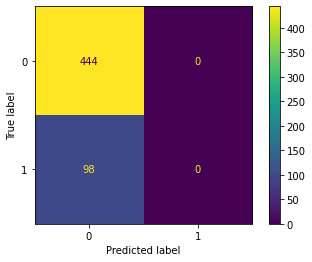

In [130]:
cm_multi = confusion_matrix(Y_test_multi_2, predictions_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi)
disp_multi.plot()
# model predicted everybody as AD. mci-ad is not predicted at all.

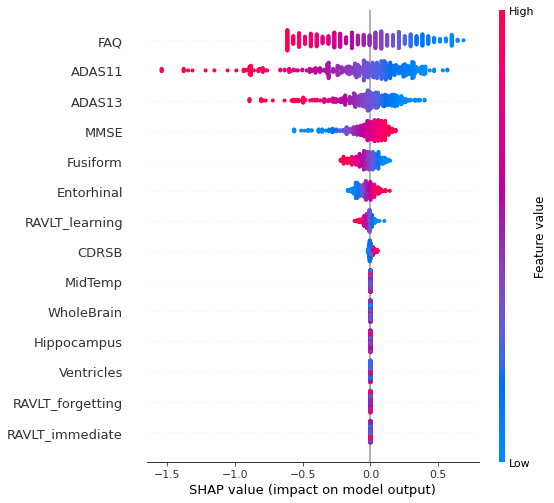

In [133]:
explainer_multi = shap.Explainer(logmodel_multi, X_train_multi_2)
shap_values_multi = explainer_multi(X_test_multi_2)
shap.summary_plot(shap_values_multi, X_test_multi_2)

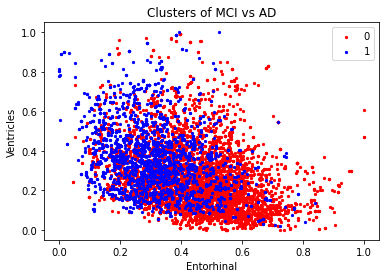

In [265]:

# Get the 2 first features from the DataFrame, this is assuming that you want to plot 2D clusters
X_train_2D = X_train[['Entorhinal','Ventricles']]
X_test_2D = X_test[['Entorhinal','Ventricles']]

# Concatenate the train and test set
X_2D = pd.concat([X_train_2D, X_test_2D])
y = np.concatenate([Y_train, Y_test])

# Plot the clusters with different colors
for i in range(2):
    # Get the index of elements with label i
    idx = (y == i)
    plt.scatter(X_2D.iloc[idx, 0], X_2D.iloc[idx, 1], c=['r' if i == 0 else 'b'], label=i, s=5)
plt.legend()

plt.xlabel('Entorhinal')
plt.ylabel('Ventricles')

plt.title('Clusters of MCI vs AD')
plt.show()

In [ ]:
# Kmeans and euclidean

In [217]:
kmeanModel=cluster.KMeans(n_clusters=2)
kmeanModel.fit_predict(X_test[['CDRSB','MMSE','FAQ','ADAS13','RAVLT_learning',  'Ventricles', 'Entorhinal', 'Fusiform']])

array([1, 1, 1, ..., 0, 0, 0])

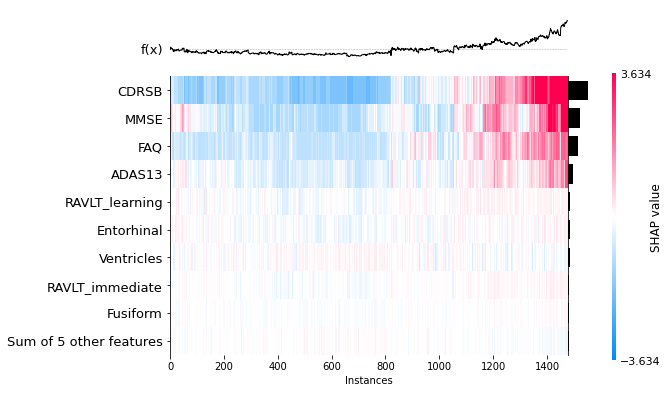

In [167]:
shap.plots.heatmap(shap_values)

### XGBoost Trial

I want to try xgboost model as well. It is prone to overfitting, less easily interpreted. Trying it with SHAP may give some insight about modeling.

In [73]:
import xgboost as xgb

In [74]:
clf_xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                            booster="gbtree",
                            seed=11,
                            #num_class=2,
                            eta=0.154,
                            #gamma=0.25,
                            max_depth=16,
                            #min_child_weight=0.07,
                            #subsample=0.81,
                            reg_lambda=0.012,
                            #reg_alpha = 0.0009,
                            #max_bin = 650,
                            num_parallel_tree=5,
                            normalize_type="forest",
                            # tree_method = "hist",
                            # colsample_bytree=0.4,
                            eval_metric='rmse', #rmsle for outliers.
                            early_stopping_rounds = 10)
# sample_type = weighted , normalize_type = forest, rate_drop 0-1, ============ booster=dart
# colsample_bytree, colsample_bylevel, colsample_bynode 

clf_xgb2.fit(X_train,
            Y_train,
            # sample_weight=sample_weights,
            verbose=True,
            eval_set=[(X_test, Y_test)])


[01:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "normalize_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.44096
[1]	validation_0-rmse:0.39634
[2]	validation_0-rmse:0.35948
[3]	validation_0-rmse:0.33175
[4]	validation_0-rmse:0.30952
[5]	validation_0-rmse:0.29078
[6]	validation_0-rmse:0.27445
[7]	validation_0-rmse:0.26388
[8]	validation_0-rmse:0.25311
[9]	validation_0-rmse:0.24553
[10]	validation_0-rmse:0.23984
[11]	validation_0-rmse:0.23622
[12]	validation_0-rmse:0.23134
[13]	validation_0-rmse:0.22860
[14]	validation_0-rmse:0.22453
[15]	validation_0-rmse:0.22071
[16]	validation_0-rmse:0.21829
[17]	validation_0-rmse:0.21775
[18]	validation_0-rmse:0.2155

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.154,
              eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.153999999, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, normalize_type='forest', num_parallel_tree=5,
              predictor='auto', random_state=11, ...)

In [75]:
predict_XG = clf_xgb2.predict(X_test)

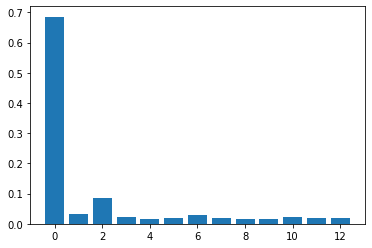

In [78]:
plt.bar(range(len(clf_xgb2.feature_importances_)), clf_xgb2.feature_importances_)
plt.show()

In [79]:
precision_recall_fscore_support(Y_test, predict_XG)
# Precision: 0.93691589 worse than LR but recall score is more important in our case.
# Recall   : 0.90315315 better than LR

(array([0.95904762, 0.93691589]),
 array([0.97388781, 0.90315315]),
 array([0.96641075, 0.91972477]),
 array([1034,  444], dtype=int64))

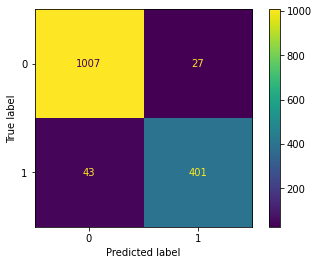

In [80]:
cm = confusion_matrix(Y_test, predict_XG)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


- XGBoost precision and recall is somewhat comparable with the logistic regression, after significant amount of hyperparameter tuning. More effort should be put in while working on the neural network model.
- Now try the SHAP for xgboost.





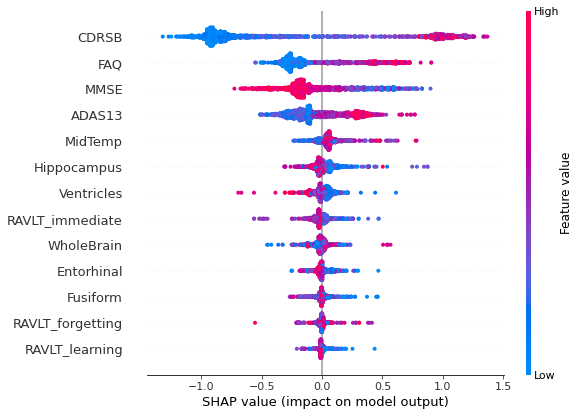

In [81]:
explainer_xg = shap.TreeExplainer(clf_xgb2, X_train)
shap_values_xg = explainer_xg(X_test)
shap.plots.beeswarm(shap_values_xg, max_display=14)
# It gives different SHAP values. They look like swords, where for logistic regression they were looking like footballs.
# https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook

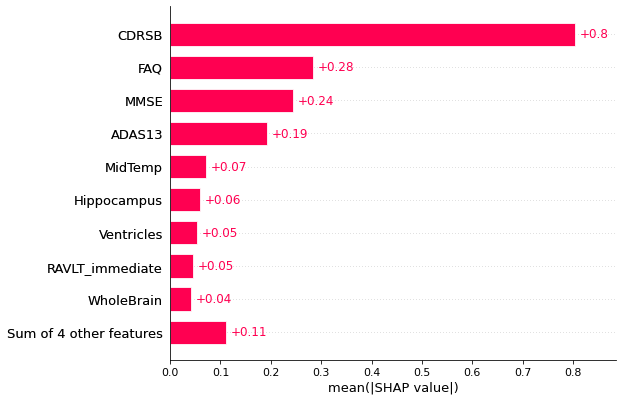

In [82]:
shap.plots.bar(shap_values_xg)

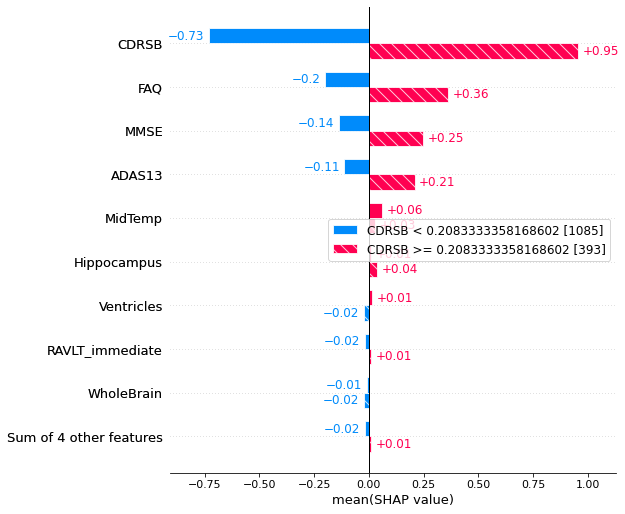

In [83]:
shap.plots.bar(shap_values_xg.cohorts(2).mean(0))

In [84]:
shap_values_mci_xg = shap_values_xg[Y_test == 0]
shap_values_ad_xg = shap_values_xg[Y_test == 1]
# look at how the importance of different features differs between MCI and AD patients

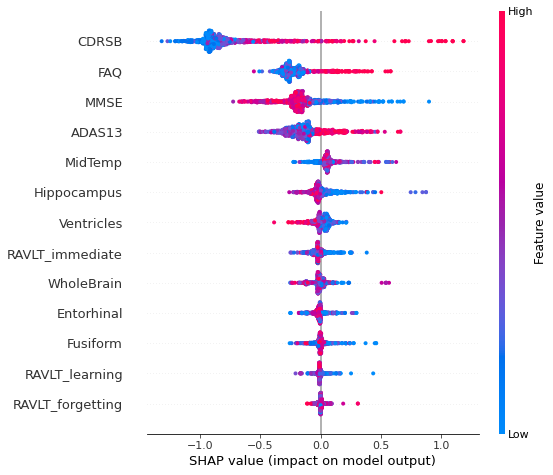

In [85]:
shap.summary_plot(shap_values_mci_xg)

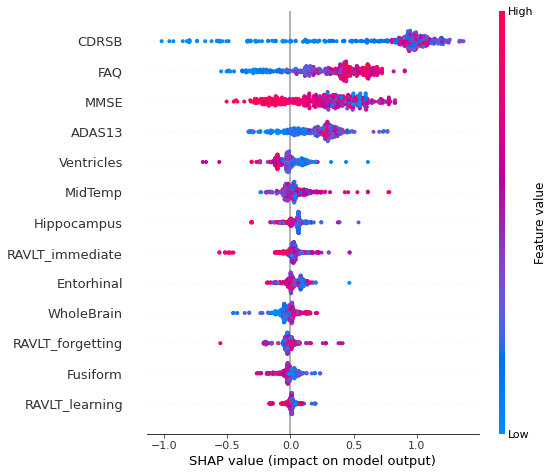

In [86]:
shap.summary_plot(shap_values_ad_xg)

In [87]:
trial_value = 0.5
false_positive_1 = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].values[0] # i_th data CDRSB column value.
    if CDRSB_value_i > trial_value and Y_test[i] == 0:
        false_positive_1.append((i,CDRSB_value_i, shap_values_xg[i].values.sum(),predict_XG[i], Y_test[i]))
# 15 out of 19 AD predictions when CDRSB shapley contribution > 0.5 are actually MCI.
# These could be suggested as pMCI patients.

In [88]:
false_positive_1

[(284, 0.9855495572533982, 2.0188802356315136, 1, 0),
 (483, 1.0361561451887247, 1.8356371195605605, 1, 0),
 (484, 1.0361561451887247, 1.8356371195605605, 1, 0),
 (593, 0.6113436486225692, 0.34064582835526375, 1, 0),
 (595, 1.0956927197577897, 2.1913149819734103, 1, 0),
 (596, 1.0956927197577897, 2.1913149819734103, 1, 0),
 (790, 0.7064871240642969, 0.2137689791664889, 0, 0),
 (807, 0.7024444714959099, 0.35603262603632163, 0, 0),
 (830, 0.6996527081355453, 1.6770128391004258, 1, 0),
 (831, 0.6751602160319453, 1.1816634419578165, 1, 0),
 (917, 0.9153336946762284, 1.6652111111745762, 1, 0),
 (996, 1.1849533681859612, 1.623257101450563, 0, 0),
 (997, 1.1849533681859612, 1.623257101450563, 0, 0),
 (1000, 1.0058044811920264, 1.2088117044227695, 1, 0),
 (1001, 1.0058044811920264, 1.2088117044227695, 1, 0),
 (1004, 0.8980460315014352, 1.7941282661325384, 1, 0),
 (1058, 0.7305504463604302, 1.1204113436208716, 1, 0),
 (1172, 0.9736160261638724, 1.4689892352142486, 1, 0),
 (1308, 1.0943492868822

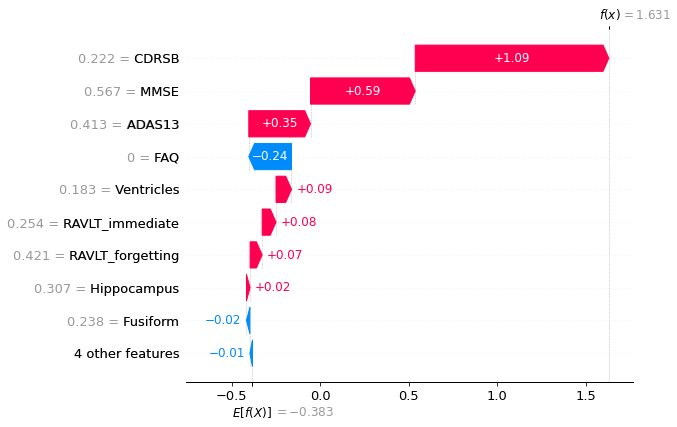

In [89]:
shap.waterfall_plot(shap_values_xg[1308]) # potential pMCI patient

In [90]:
shap.initjs()
ind = 77
shap.plots.force(shap_values_xg[ind])
# base value -0.3832 < 1.90, so it's predicted as 1 = AD.

In [107]:
predict_XG[77]

1

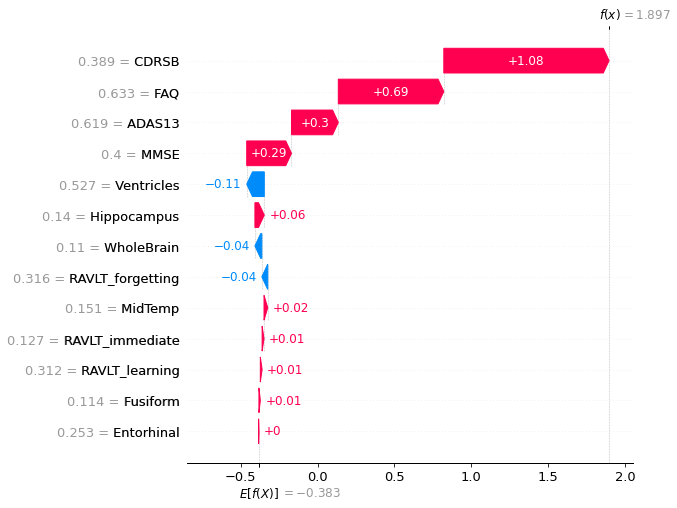

In [237]:
shap.waterfall_plot(shap_values_xg[77], max_display=14)

In [236]:
shap_values_xg[77].values

array([ 1.07544544,  0.3046346 ,  0.29137153,  0.01231909,  0.01160847,
       -0.03857448,  0.68659254, -0.11422553,  0.06092022, -0.04498745,
        0.00201673,  0.00914044,  0.02430442])

In [108]:
trial_value = 0.18
range_list = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if abs(trial_value - CDRSB_value_i) < 0.041:
        range_list.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i]))

In [109]:
range_list

[(0, 0.19444445, 0.153972325460054, 1),
 (31, 0.16666667, 0.049786876196740194, 0),
 (37, 0.19444445, -0.32311758311465383, 0),
 (47, 0.19444445, 0.2648786666779779, 0),
 (81, 0.16666667, -0.20456006890395656, 0),
 (101, 0.16666667, -0.5101923531154171, 0),
 (103, 0.16666667, -0.3435300321620889, 0),
 (116, 0.16666667, -0.42196482793660833, 0),
 (135, 0.19444445, -0.46265595726901665, 0),
 (136, 0.19444445, -0.46265595726901665, 0),
 (158, 0.19444445, 0.31295559906226117, 1),
 (159, 0.19444445, 0.19187246685673018, 1),
 (171, 0.16666667, 0.447066827393719, 1),
 (176, 0.16666667, -0.5842439298820682, 0),
 (177, 0.16666667, -0.5842439298820682, 0),
 (182, 0.16666667, -0.009113185679307207, 0),
 (189, 0.16666667, 0.04552666169591248, 0),
 (190, 0.19444445, -0.3079915487684775, 0),
 (206, 0.16666667, -0.5631348209036514, 0),
 (207, 0.16666667, -0.5716687197377905, 0),
 (208, 0.19444445, 0.04142947600921616, 1),
 (209, 0.19444445, 0.04142947600921616, 1),
 (213, 0.16666667, -0.4898308781196

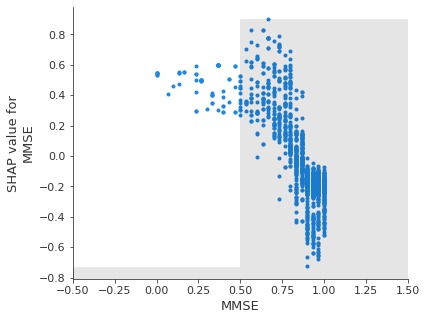

In [101]:
shap.plots.scatter(shap_values_xg[:, shap_values_xg.abs.mean(0).argsort[-3]]) # -1, -2, -3, -4 are the most important ones.
# CDRSB, MMSE, FAQ, ADAS13. The order is the same with LR model.

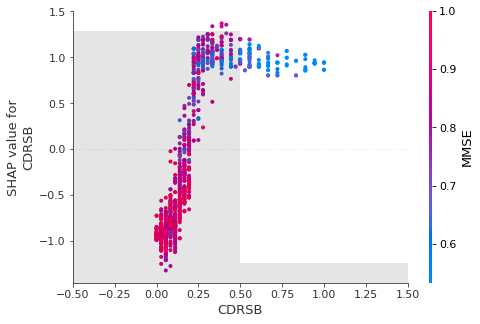

In [135]:
shap.plots.scatter(shap_values_xg[:,"CDRSB"],color=shap_values_xg[:,"MMSE"])

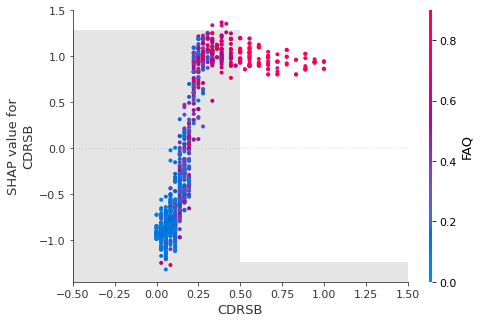

In [136]:
shap.plots.scatter(shap_values_xg[:,"CDRSB"],color=shap_values_xg[:,"FAQ"])

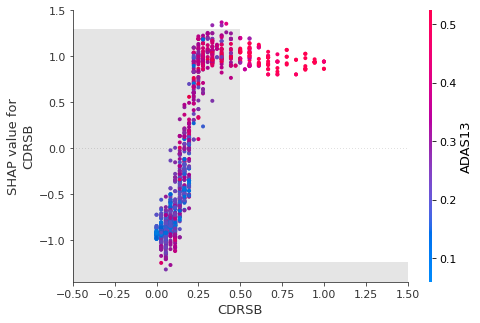

In [137]:
shap.plots.scatter(shap_values_xg[:,"CDRSB"],color=shap_values_xg[:,"ADAS13"])

In [111]:
shap.plots.force(shap_values_xg)

In [112]:
shap.plots.force(shap_values_xg[46])

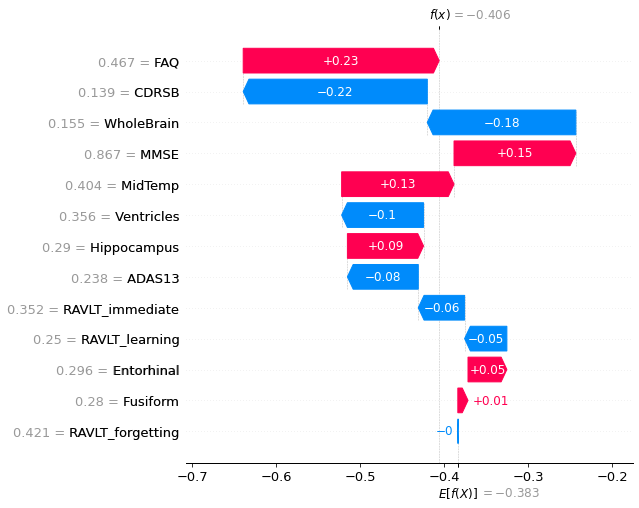

In [113]:
shap.waterfall_plot(shap_values_xg[46], max_display=14)

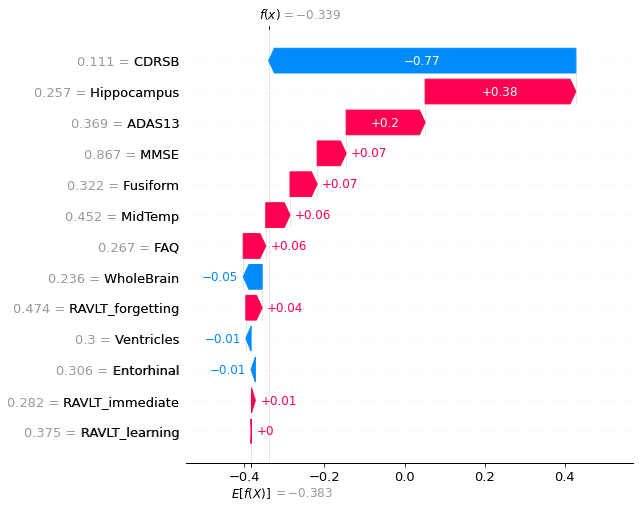

In [114]:
shap.waterfall_plot(shap_values_xg[1459], max_display=14)
# This is a great case. f(x) is under 0.05 of the base value -0.38
# As we can see contribution of CDRSB feature to this sample's shapley_value is great.
# Let's compare CDRSB = 0.111 samples.

In [115]:
trial_value = 0.111
range_list = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if abs(trial_value - CDRSB_value_i) < 0.01:
        range_list.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i]))

In [116]:
range_list

[(9, 0.11111111, -0.8031785650621168, 0),
 (10, 0.11111111, -0.7981880176078994, 0),
 (11, 0.11111111, -0.7981880176078994, 0),
 (12, 0.11111111, -0.8527307299664244, 0),
 (13, 0.11111111, -0.9613506243564188, 0),
 (14, 0.11111111, -1.0777356642298401, 0),
 (52, 0.11111111, -0.6209283140569459, 0),
 (53, 0.11111111, -0.6629651809256757, 0),
 (54, 0.11111111, -0.4666987626685295, 0),
 (55, 0.11111111, -0.4666987626685295, 0),
 (74, 0.11111111, -0.754477260413114, 1),
 (83, 0.11111111, -0.3456175580155104, 0),
 (84, 0.11111111, -0.15280495143961162, 0),
 (89, 0.11111111, -0.3657742456730921, 0),
 (102, 0.11111111, -1.118877990177134, 0),
 (141, 0.11111111, -0.8317516413243721, 0),
 (142, 0.11111111, -1.0649367788713426, 0),
 (143, 0.11111111, -1.0822257075092057, 0),
 (169, 0.11111111, -0.5695363687118515, 0),
 (181, 0.11111111, -1.0148879577848129, 0),
 (216, 0.11111111, -0.8568624653364532, 0),
 (233, 0.11111111, -0.6260455407347763, 0),
 (234, 0.11111111, -0.7056887610029662, 0),
 (27

In [91]:
def Sort_Tuple(tup, i):
 
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using i-th element of
    # sublist lambda has been used
    tup.sort(key = lambda x: x[i])
    return tup
 
Sort_Tuple(range_list, 2)
# All but one (74) are predicted as MCI. But shapley value contribution is between [-1.118, 0.005]
# We cannot see this phenomenon in the logistic regression case.

NameError: name 'range_list' is not defined

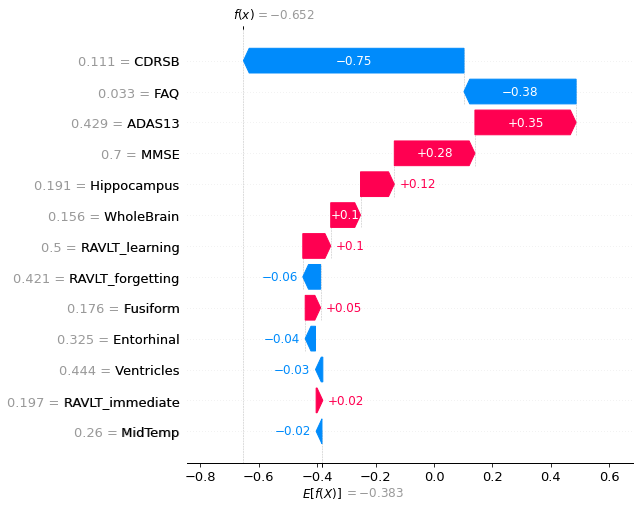

In [197]:
shap.waterfall_plot(shap_values_xg[74], max_display=14)

- 74th index from Logistic Regression shapley.
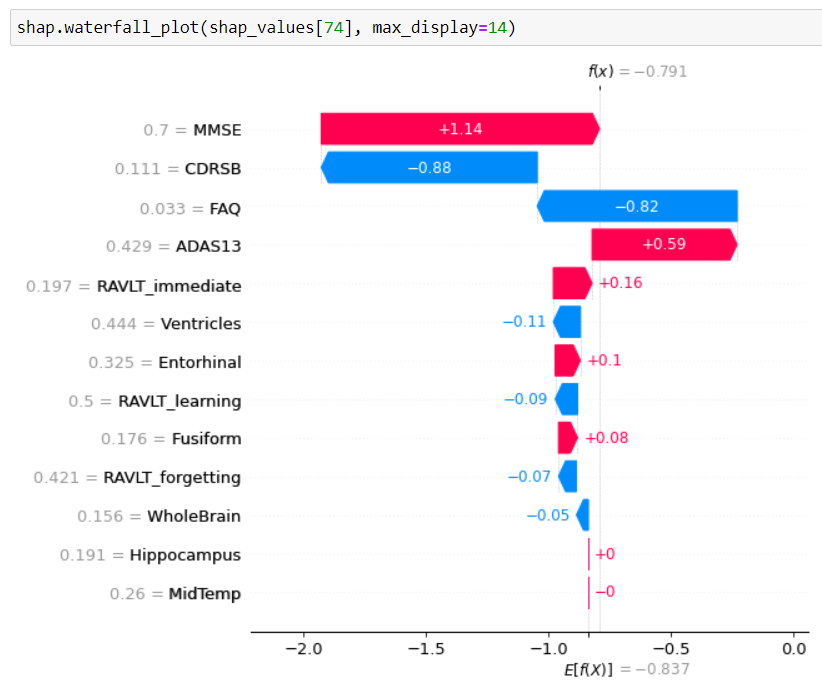

In [146]:
shap.plots.force(shap_values_xg[74])

In [147]:
predictions[74]
# It's interestingly predicted as MCI by the logistic regression classifier.
# Let's look at the shapley value and prediction conflicts.

0

### Predictions conflicted with Shapley value, base value E[f(x)]

In [120]:
conflict_list = []
for i in range(len(predictions)):
    if (predictions[i] == 0 and shap_values[i].values.sum() >= -0.8367) or (predictions[i] == 1 and shap_values[i].values.sum() <= -0.8367):
        conflict_list.append(i)

In [121]:
len(conflict_list) # 142

142

In [153]:
conflict_list_xg = []
for i in range(len(predict_XG)):
    if (predict_XG[i] == 0 and shap_values_xg[i].values.sum() >= -0.3832) or (predict_XG[i] == 1 and shap_values_xg[i].values.sum() <= -0.3832):
        conflict_list_xg.append(i)

In [154]:
len(conflict_list_xg) # 91

91

In [159]:
conflict_truth_list = []
for i in conflict_list_xg:
    if Y_test[i] == predict_XG[i]:
        conflict_truth_list.append(i)

len(conflict_truth_list)
# 78/91 are correctly classified. 0.857 accuracy. it's not bad, but it is lower than average.

78

In [124]:
# let's give it a range of 10% # 87
# range static 0.1 0.1         # 71
# range static 0.2 0.2         # 66
# range static 0.5 0.5         # 41
# range static 1.0 1.0         # 18


In [125]:
conflict_list_xg_ranged = []
for i in range(len(predictions)):
    if (predict_XG[i] == 0 and shap_values_xg[i].values.sum() >= 0.6168) or (predict_XG[i] == 1 and shap_values_xg[i].values.sum() <= -1.3832):
        conflict_list_xg_ranged.append(i)

In [126]:
len(conflict_list_xg_ranged) # 87

18

### Plot the CDRSB = 0.111 samples according to shapley

In [153]:
trial_value = 0.111
range_list_xg_w_s = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if abs(trial_value - CDRSB_value_i) < 0.01:
        range_list_xg_w_s.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], shap_values_xg[i].values.sum()))

In [154]:
Sort_Tuple(range_list_xg_w_s, 4)
# 4th index of the tuple is shapley value for this sample.
# it ranges [-1.63, 1.38]. And in between, the shapley contr. from CDRSB changes. Let's plot that.

[(679, 0.11111111, -1.000433149501914, 0, -1.6303977949194812),
 (1307, 0.11111111, -1.1127796293701977, 0, -1.533818345463078),
 (12, 0.11111111, -0.8527307299664244, 0, -1.5328194949762834),
 (455, 0.11111111, -0.9767012037825771, 0, -1.5250255132389432),
 (419, 0.11111111, -0.9582884466159157, 0, -1.5239597427787157),
 (420, 0.11111111, -0.9582884466159157, 0, -1.5239597427787157),
 (1111, 0.11111111, -0.8684981669974513, 0, -1.5201935358633638),
 (708, 0.11111111, -0.7755623227369506, 0, -1.515051930251757),
 (1071, 0.11111111, -0.9116740405466408, 0, -1.5150519194950176),
 (1030, 0.11111111, -0.7257470877934247, 0, -1.5150519173798236),
 (1031, 0.11111111, -0.7257470877934247, 0, -1.5150519173798236),
 (747, 0.11111111, -0.7643275083519984, 0, -1.515051916306911),
 (561, 0.11111111, -0.8127348134311615, 0, -1.513838228030945),
 (562, 0.11111111, -0.8127348134311615, 0, -1.513838228030945),
 (557, 0.11111111, -0.7743521038483595, 0, -1.5119276520163836),
 (505, 0.11111111, -0.85368

In [155]:
indexes = []
x_contr = []
y_total = []
for i in range(len(range_list_xg_w_s)):
    indexes.append(range_list_xg_w_s[i][0])
    x_contr.append(range_list_xg_w_s[i][2])
    y_total.append(range_list_xg_w_s[i][4])

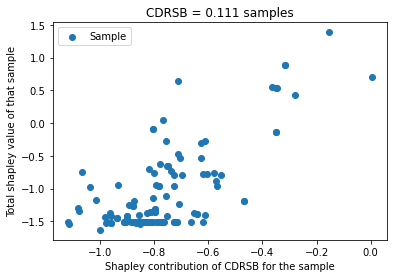

In [156]:
fig, ax = plt.subplots()

ax.scatter(x_contr, y_total, label='Sample')

ax.set_xlabel('Shapley contribution of CDRSB for the sample')
ax.set_ylabel('Total shapley value of that sample')
ax.legend()
plt.title('CDRSB = 0.111 samples')

plt.show()

# We can see that there is a correlation but, it has noise. 
# I assume those are the patients that we need to worry about.




### Plot an arbitrary range of shapley value instances for CDRSB = 0.111

In [187]:
trial_value = 0.111
range_list_xg_w_s = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if abs(trial_value - CDRSB_value_i) < 0.01 and (-0.70 < shap_values_xg[i].values.sum() < -0.01):
        range_list_xg_w_s.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], shap_values_xg[i].values.sum()))
Sort_Tuple(range_list_xg_w_s, 4)

[(1109, 0.11111111, -0.7486396993428934, 0, -0.6537889559267933),
 (1110, 0.11111111, -0.7486396993428934, 0, -0.6537889559267933),
 (952, 0.11111111, -0.752968460454722, 0, -0.6496900694644138),
 (540, 0.11111111, -0.7769945141416974, 0, -0.6237078489067789),
 (234, 0.11111111, -0.7056887610029662, 0, -0.5391170395108565),
 (233, 0.11111111, -0.6260455407347763, 0, -0.5391170267124471),
 (541, 0.11111111, -0.7125333060196135, 0, -0.4762815952748133),
 (558, 0.11111111, -0.6277689772023587, 0, -0.30745934048376516),
 (986, 0.11111111, -0.6110148943588137, 0, -0.278106004331421),
 (74, 0.11111111, -0.754477260413114, 1, -0.2685606068327252),
 (481, 0.11111111, -0.348654546480393, 0, -0.13204756551094757),
 (482, 0.11111111, -0.348654546480393, 0, -0.13204756551094757),
 (716, 0.11111111, -0.8052455161995021, 0, -0.08364953558197159),
 (717, 0.11111111, -0.8052455161995021, 0, -0.08364953558197159)]

In [188]:
indexes = []
x_contr = []
y_total = []
for i in range(len(range_list_xg_w_s)):
    indexes.append(range_list_xg_w_s[i][0])
    x_contr.append(range_list_xg_w_s[i][2])
    y_total.append(range_list_xg_w_s[i][4])

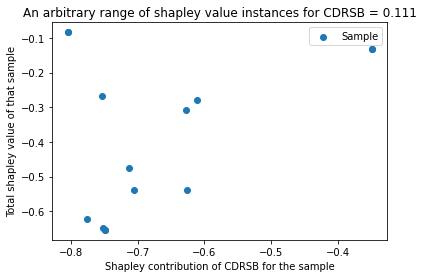

In [189]:
fig, ax = plt.subplots()

ax.scatter(x_contr, y_total, label='Sample')

ax.set_xlabel('Shapley contribution of CDRSB for the sample')
ax.set_ylabel('Total shapley value of that sample')
ax.legend()
plt.title('An arbitrary range of shapley value instances for CDRSB = 0.111')

plt.show()


### Plotting the conflicting results of XGBoost

In [148]:
range_list_xg_conflict = []
conflict_list_xg # ???
for i in conflict_list_xg:
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    
    range_list_xg_conflict.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], shap_values_xg[i].values.sum()))

NameError: name 'conflict_list_xg' is not defined

In [195]:
indexes = []
x_contr = []
y_total = []
for i in range(len(range_list_xg_conflict)):
    indexes.append(range_list_xg_conflict[i][0])
    x_contr.append(range_list_xg_conflict[i][2])
    y_total.append(range_list_xg_conflict[i][4])

No handles with labels found to put in legend.


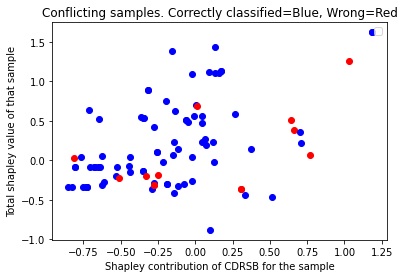

In [196]:
fig, ax = plt.subplots()
counter = 0

for i, ele in enumerate(indexes):
    if ele in conflict_truth_list:
        color = 'blue'
    else:
        counter += 1
        color = 'red'
    ax.scatter(x_contr[i], y_total[i], color=color) # , label='Sample'

ax.set_xlabel('Shapley contribution of CDRSB for the sample')
ax.set_ylabel('Total shapley value of that sample')
ax.legend()
plt.title('Conflicting samples. Correctly classified=Blue, Wrong=Red')

plt.show()

# We can see that wrong classified conflicted samples are mixed into 
# correctly classified conflicting samples. So, other features than CDRSB are also important to check
# when deciding a person will convert to AD or not.

**[-0.77, 0.32] interval for shapley values, "f(x)", can be assumed questionable classifications**
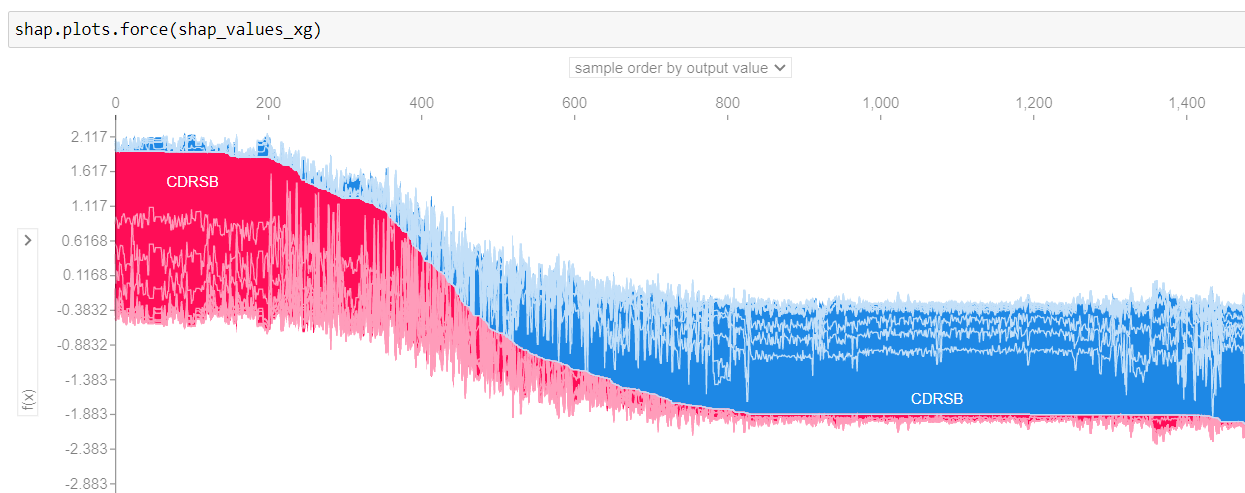

In [334]:

range_list_xg_que = []
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if -0.77 < shap_values_xg[i].values.sum() < 0.32:
        range_list_xg_que.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], Y_test[i], shap_values_xg[i].values.sum()))
Sort_Tuple(range_list_xg_que, 5)

[(680, 0.11111111, -0.8010887978598475, 0, 0, -0.7651247606863762),
 (1068, 0.11111111, -0.578419291600585, 0, 0, -0.7640936347999742),
 (1244, 0.16666667, -0.2811709615285508, 0, 0, -0.7625719456419392),
 (645, 0.2777778, 0.5964333106542472, 0, 1, -0.7589587995790499),
 (466, 0.1388889, -0.27294883266673425, 0, 1, -0.7509478845704144),
 (142, 0.11111111, -1.0649367788713426, 0, 0, -0.7503087093999785),
 (73, 0.055555556, -0.9488893370877486, 0, 0, -0.7443155152483086),
 (1329, 0.027777778, -1.2477901557715085, 0, 0, -0.7443155066635518),
 (422, 0.055555556, -0.7572791019233409, 0, 0, -0.7416289071107165),
 (839, 0.055555556, -0.9663647026044783, 0, 0, -0.7414218204893405),
 (1177, 0.055555556, -0.9505981519629131, 0, 0, -0.7414218151791282),
 (669, 0.16666667, -0.2529023576329928, 0, 0, -0.7374409650507733),
 (180, 0.083333336, -0.9355676399567164, 0, 0, -0.7343832205406216),
 (1098, 0.11111111, -0.7391369727061828, 0, 1, -0.7323193564668692),
 (1161, 0.083333336, -0.7976856104866602,

In [335]:
indexes = []
pred = []
truth = []
for i in range(len(range_list_xg_que)):
    indexes.append(range_list_xg_que[i][0])
    pred.append(range_list_xg_que[i][3])
    truth.append(range_list_xg_que[i][4])
    
que_truth_list = []
for i, ele in enumerate(pred):
    if truth[i] == ele:
        que_truth_list.append(i)

In [336]:
print(len(que_truth_list), len(pred))
# 115/139 = 0.827 correct/total predictions. Accuracy dropped.

115 139


In [191]:
# only the wrongly classified MCI ones. (classified as AD)
range_list_xg_que_wro = []
counter = 0
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if -1 < shap_values_xg[i].values.sum() < 0.5 and Y_test[i] == 1:
        counter +=1
    if -1 < shap_values_xg[i].values.sum() < 0.5 and predict_XG[i] != Y_test[i] and Y_test[i] == 1:
        range_list_xg_que_wro.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], Y_test[i], shap_values_xg[i].values.sum()))
Sort_Tuple(range_list_xg_que_wro, 5)

[(8, 0.055555556, -0.8023810454597696, 0, 1, -0.8768170778387866),
 (1097, 0.083333336, -0.7405126828234643, 0, 1, -0.8659995185475053),
 (645, 0.2777778, 0.5964333106542472, 0, 1, -0.7589587995790499),
 (466, 0.1388889, -0.27294883266673425, 0, 1, -0.7509478845704144),
 (1098, 0.11111111, -0.7391369727061828, 0, 1, -0.7323193564668692),
 (37, 0.19444445, -0.32311758311465383, 0, 1, -0.7230302679626404),
 (1130, 0.083333336, -0.5622207719064317, 0, 1, -0.719591389634188),
 (1131, 0.083333336, -0.5622207719064317, 0, 1, -0.719591389634188),
 (585, 0.11111111, -0.8193192912975792, 0, 1, -0.7046918769692275),
 (1099, 0.16666667, -0.17696737087273504, 0, 1, -0.6746805744761514),
 (1100, 0.16666667, -0.17696737087273504, 0, 1, -0.6746805744761514),
 (771, 0.16666667, -0.3144261100899894, 0, 1, -0.634906439960687),
 (772, 0.16666667, -0.3144261100899894, 0, 1, -0.634906439960687),
 (519, 0.1388889, -0.54081323556602, 0, 1, -0.6302408520881727),
 (378, 0.22222222, 0.3052321017568465, 0, 1, -0

In [192]:
print(counter, len(range_list_xg_que_wro))

43 24


In [187]:
indexes = []
x_contr = []
y_total = []
for i in range(len(range_list_xg_que_wro)):
    indexes.append(range_list_xg_que_wro[i][0])
    x_contr.append(range_list_xg_que_wro[i][1])
    y_total.append(range_list_xg_que_wro[i][5])

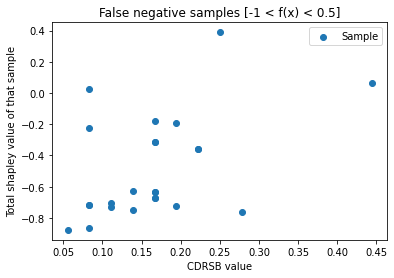

In [188]:
fig, ax = plt.subplots()
counter = 0

ax.scatter(x_contr, y_total, label='Sample')

ax.set_xlabel('CDRSB value')
ax.set_ylabel('Total shapley value of that sample')
ax.legend()
plt.title('False negative samples [-1 < f(x) < 0.5]')

plt.show()
 

In [208]:
# only the wrongly classified MCI ones. (classified as AD)
range_list_xg_que_wro = []
counter = 0
for i in range(len(shap_values_xg)):
    
    CDRSB_value_i = shap_values_xg[i].data[0] # i_th data CDRSB column value.
    if -0.3 < shap_values_xg[i].values.sum() < 1 and Y_test[i] == 0:
        counter +=1
    if -0.3 < shap_values_xg[i].values.sum() < 1 and predict_XG[i] != Y_test[i] and Y_test[i] == 0:
        range_list_xg_que_wro.append((i,CDRSB_value_i, shap_values_xg[i].values[0],predict_XG[i], Y_test[i], shap_values_xg[i].values.sum()))
Sort_Tuple(range_list_xg_que_wro, 5)

[(74, 0.11111111, -0.754477260413114, 1, 0, -0.2685606068327252),
 (593, 0.22222222, 0.6113436486225692, 1, 0, 0.34064582835526375),
 (767, 0.16666667, -0.005695333954645321, 1, 0, 0.4188710081964382),
 (525, 0.1388889, 0.31602666799444706, 1, 0, 0.7006719109425467),
 (678, 0.19444445, 0.2666687460662797, 1, 0, 0.8130397570652893),
 (719, 0.16666667, 0.0074503380514215675, 1, 0, 0.9129856202111841),
 (840, 0.1388889, 0.00624906774610281, 1, 0, 0.9246718021760171)]

In [209]:
print(counter, len(range_list_xg_que_wro))

62 7


In [210]:
indexes = []
x_contr = []
y_total = []
for i in range(len(range_list_xg_que_wro)):
    indexes.append(range_list_xg_que_wro[i][0])
    x_contr.append(range_list_xg_que_wro[i][2])
    y_total.append(range_list_xg_que_wro[i][5])

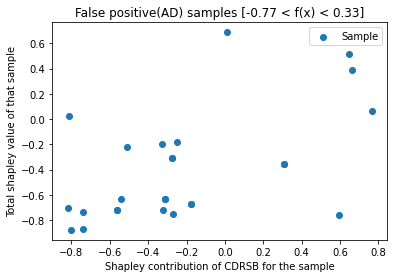

In [207]:
fig, ax = plt.subplots()
counter = 0

ax.scatter(x_contr, y_total, label='Sample')

ax.set_xlabel('Shapley contribution of CDRSB for the sample')
ax.set_ylabel('Total shapley value of that sample')
ax.legend()
plt.title('False positive(AD) samples [-0.77 < f(x) < 0.33]')

plt.show()

# As we can see the total shapley 

### Considering the big 4 features: CDRSB, MMSE, FAQ, ADAS13

In [ ]:
# We considered CDRSB, but we should look into the 4 features
# Let's look at the sum of absolute values of the shapley contributions of the big 4.


In [242]:
# look at the questionable ones: sum < 1
# 'CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ' 
# 0, 1, 2, 6
big_four_sum_abs_que = []
counter_true = 0
for i in range(len(shap_values_xg)):
    sum_abs = abs(shap_values_xg[i].values[0])+abs(shap_values_xg[i].values[1])+abs(shap_values_xg[i].values[2])+abs(shap_values_xg[i].values[6])
    if sum_abs < 1 and predict_XG[i] != Y_test[i]:
        big_four_sum_abs_que.append((i, shap_values_xg[i].values[0], shap_values_xg[i].values[1], shap_values_xg[i].values[2], shap_values_xg[i].values[6], shap_values_xg[i].values.sum()))
    elif sum_abs < 1 and predict_XG[i] == Y_test[i]:
        counter_true+=1
Sort_Tuple(big_four_sum_abs_que, 5)
print(len(big_four_sum_abs_que), counter_true)
# 90/107 = 0.841 accurately classified when the big 4 sum is less than 1.

17 90


In [226]:
# look at the questionable ones: sum < 0.6
# 'CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ' 
# 0, 1, 2, 6
big_four_sum_abs_que = []
counter_true = 0
for i in range(len(shap_values_xg)):
    sum_abs = abs(shap_values_xg[i].values[0]+shap_values_xg[i].values[1]+shap_values_xg[i].values[2]+shap_values_xg[i].values[6])
    if sum_abs < 0.6 and predict_XG[i] != Y_test[i] and Y_test[i] == 0:
        big_four_sum_abs_que.append((i, shap_values_xg[i].values[0], shap_values_xg[i].values[1], shap_values_xg[i].values[2], shap_values_xg[i].values[6], shap_values_xg[i].values.sum()))
    elif sum_abs < 0.6 and predict_XG[i] == Y_test[i] and Y_test[i] == 0:
        counter_true+=1
Sort_Tuple(big_four_sum_abs_que, 5)
print(len(big_four_sum_abs_que), counter_true)
# 13/20 = 0.65 accurately classified when the big 4 sum is less than 0.6
# 

6 68


In [253]:
indexes = []
for i in range(len(big_four_sum_abs_que)):
    indexes.append(big_four_sum_abs_que[i][0])
indexes

[37, 1099, 1100, 771, 772, 378, 379, 1355, 1356, 1128, 817, 810, 1018]

In [216]:
# look at the questionable ones: sum < 0.6
# 'CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ' 
# 0, 1, 2, 6
big_four_sum_abs_que = []
counter_true = 0
for i in range(len(shap_values_xg)):
    sum_abs = abs(shap_values_xg[i].values.sum())
    if sum_abs < 0.5 and predict_XG[i] != Y_test[i] and abs(shap_values_xg[i].values[0]+shap_values_xg[i].values[1]+shap_values_xg[i].values[2]+shap_values_xg[i].values[6]) < 0.4:
        big_four_sum_abs_que.append((i, shap_values_xg[i].values[0], shap_values_xg[i].values[1], shap_values_xg[i].values[2], shap_values_xg[i].values[6], shap_values_xg[i].values.sum()))
    elif sum_abs < 0.5 and predict_XG[i] == Y_test[i] and abs(shap_values_xg[i].values[0]+shap_values_xg[i].values[1]+shap_values_xg[i].values[2]+shap_values_xg[i].values[6]) < 0.4:
        counter_true+=1
Sort_Tuple(big_four_sum_abs_que, 5)
print(len(big_four_sum_abs_que), counter_true)
# 13/20 = 0.65 accurately classified when the big 4 sum is less than 0.6
# 

8 33


In [361]:
indexes = []
for i in range(len(big_four_sum_abs_que)):
    indexes.append(big_four_sum_abs_que[i][0])
indexes

[645,
 466,
 37,
 585,
 1099,
 1100,
 771,
 772,
 378,
 379,
 1420,
 1421,
 1355,
 1356,
 74,
 1128,
 817,
 810,
 1363,
 593,
 380,
 767,
 395,
 1018,
 525]

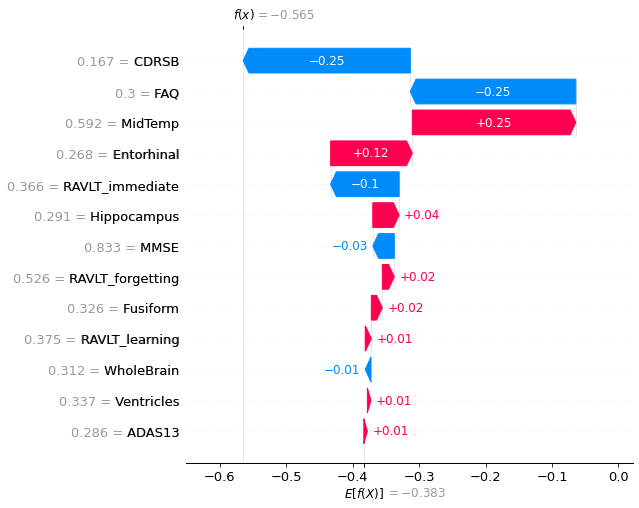

In [227]:
shap.waterfall_plot(shap_values_xg[810], max_display=14)

In [352]:
shap_values_xg[37].values.sum()

-0.7230302679626404

### Cognitive features alone

In [137]:
X_train_cogn = pd.DataFrame(X_train, columns = ['CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ'])
X_test_cogn = pd.DataFrame(X_test, columns = ['CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ'])

In [138]:
X_train_cogn.describe()

CDRSB       ADAS13         MMSE  RAVLT_immediate  RAVLT_learning  \
count  5966.000000  5966.000000  5966.000000      5966.000000     5966.000000   
mean      0.165135     0.252394     0.849922         0.401517        0.440249   
std       0.159652     0.146781     0.148738         0.166865        0.141259   
min       0.000000     0.000000     0.000000         0.000000        0.000000   
25%       0.055556     0.141176     0.800000         0.293333        0.315789   
50%       0.111111     0.223529     0.900000         0.386667        0.421053   
75%       0.222222     0.333294     0.966667         0.493333        0.526316   
max       1.000000     1.000000     1.000000         1.000000        1.000000   

       RAVLT_forgetting          FAQ  
count       5966.000000  5966.000000  
mean           0.634235     0.254202  
std            0.090364     0.281350  
min            0.000000     0.000000  
25%            0.576923     0.033333  
50%            0.653846     0.133333  
75%            0.692308     0.433333  
max            1.000000     1.000000

In [139]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_cogn, Y_train)
predictions = logmodel.predict(X_test_cogn)

In [140]:
score = logmodel.score(X_test_cogn,Y_test)
score # same score with all features

0.9533152909336942

In [141]:
precision_recall_fscore_support(Y_test, predictions)  # same score with all features

(array([0.94634598, 0.97229219]),
 array([0.9893617 , 0.86936937]),
 array([0.96737589, 0.91795482]),
 array([1034,  444], dtype=int64))

### Explain the model and *cognitive* features using SHAP

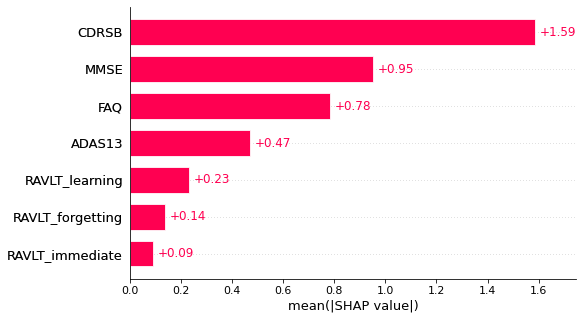

In [142]:
explainer = shap.Explainer(logmodel, X_train_cogn)
shap_values = explainer(X_test_cogn)
shap.plots.bar(shap_values)

### MRI features alone

In [143]:
X_train_MRI = pd.DataFrame(X_train, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp'])
X_test_MRI = pd.DataFrame(X_test, columns = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp'])

In [144]:
X_train_MRI.describe()

Ventricles  Hippocampus   WholeBrain   Entorhinal     Fusiform  \
count  5966.000000  5966.000000  5966.000000  5966.000000  5966.000000   
mean      0.290581     0.350654     0.223098     0.434922     0.292217   
std       0.171449     0.106886     0.068815     0.157655     0.094136   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.160190     0.269367     0.172458     0.317872     0.228645   
50%       0.262699     0.346481     0.218875     0.439319     0.291867   
75%       0.389578     0.422085     0.271441     0.547731     0.351712   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           MidTemp  
count  5966.000000  
mean      0.278197  
std       0.081561  
min       0.000000  
25%       0.222129  
50%       0.283033  
75%       0.335862  
max       1.000000

In [145]:
logmodel = LogisticRegression(max_iter = 2000, penalty="l1",tol = 10**-3, solver = "saga")
logmodel.fit(X_train_MRI, Y_train)
predictions = logmodel.predict(X_test_MRI)

In [146]:
score = logmodel.score(X_test_MRI,Y_test)
score # worse

0.7584573748308525

- With only MRI features,

In [147]:
precision_recall_fscore_support(Y_test, predictions, zero_division=0)  # Low recall

(array([0.77542718, 0.6746988 ]),
 array([0.92166344, 0.37837838]),
 array([0.84224481, 0.48484848]),
 array([1034,  444], dtype=int64))

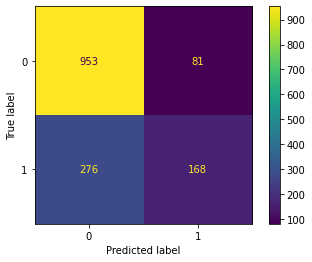

In [148]:
cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Explain the model and *MRI* features using SHAP

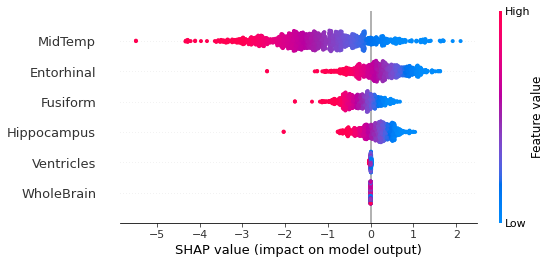

In [149]:
explainer = shap.Explainer(logmodel, X_train_MRI)
shap_values = explainer(X_test_MRI)
shap.plots.beeswarm(shap_values)

- Too many false negatives. Low recall.
- Ventricles and WholeBrain features doesn't contribute. We can eliminate them maybe.
- However, their shapley values are larger when they are with cognitive features.

### KMeans Interclass and Intraclass categories 

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, preprocessing, model_selection, neighbors, cluster
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import pandas as pd

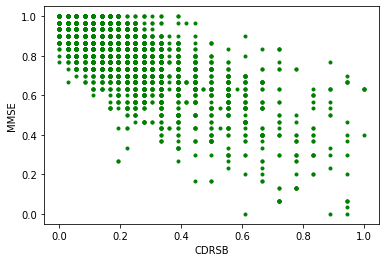

In [152]:
plt.plot(X_train_cogn['CDRSB'], X_train_cogn['MMSE'], 'g.')
plt.xlabel('CDRSB')
plt.ylabel('MMSE')
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


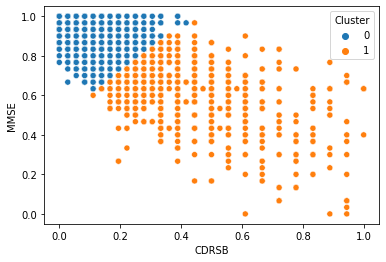

In [153]:
clustering=cluster.KMeans(n_clusters=2)
clusters = clustering.fit_predict(X_train_cogn[['CDRSB','MMSE']])
X_train_cogn['Cluster'] = clusters
sns.scatterplot('CDRSB', 'MMSE', data=X_train_cogn, hue='Cluster')
plt.show()

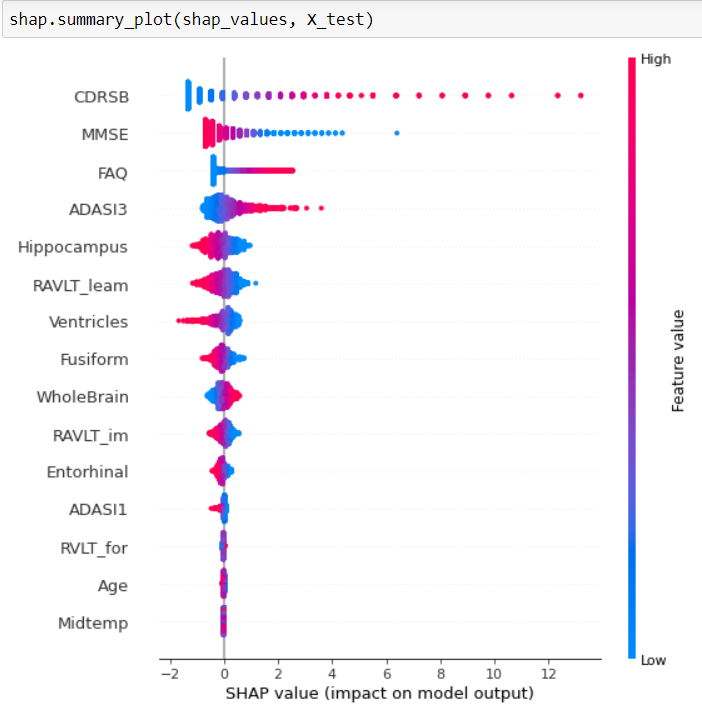

- Let's use some of these features

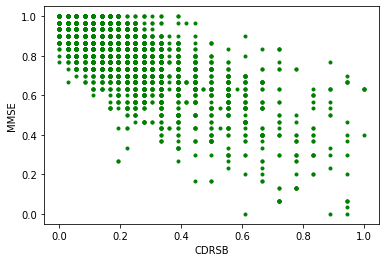

In [193]:
plt.plot(X_train['CDRSB'], X_train['MMSE'], 'g.')
plt.xlabel('CDRSB')
plt.ylabel('MMSE')
plt.show()

In [165]:
X_train_MCI = X_train[Y_train == 0]
X_train_AD = X_train[Y_train == 1]
X_test_MCI = X_test[Y_test == 0]
X_test_AD = X_test[Y_test == 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


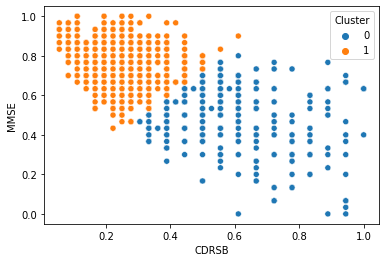

In [155]:
clustering=cluster.KMeans(n_clusters=2)
clusters = clustering.fit_predict(X_train_AD[['CDRSB','MMSE']])
X_train_AD['Cluster'] = clusters
sns.scatterplot('CDRSB', 'MMSE', data=X_train_AD, hue='Cluster')
plt.show()

In [217]:
kmeanModel=cluster.KMeans(n_clusters=2)
kmeanModel.fit_predict(X_test[['CDRSB','MMSE','FAQ','ADAS13','RAVLT_learning',  'Ventricles', 'Entorhinal', 'Fusiform']])

array([1, 1, 1, ..., 0, 0, 0])

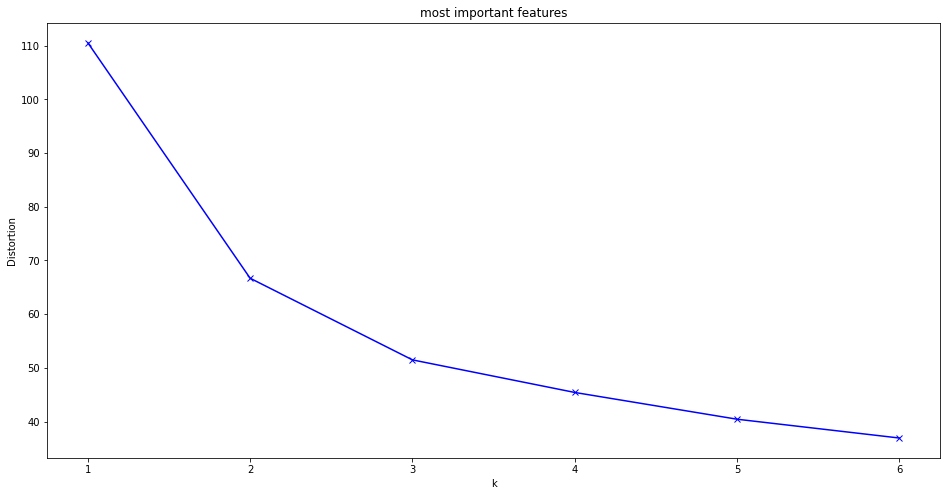

In [167]:
distortions = []
for i in range(1,7):
    kmeanModel=cluster.KMeans(n_clusters=i)
    kmeanModel.fit_predict(X_test_AD[['CDRSB','MMSE','FAQ','ADAS13','RAVLT_learning',  'Ventricles', 'Entorhinal', 'Fusiform']])
    distortions.append(kmeanModel.inertia_)
    
    
    
    
    
    #clustering=cluster.KMeans(n_clusters=i)
    #clusters = clustering.fit_predict(MallData[['Spending Score (1-100)', 'Annual Income (k$)']])
    #distortions.append(clusters.inertia_)
    #MallData['Cluster'] = clusters
    #sns.scatterplot('Spending Score (1-100)', 'Annual Income (k$)', data=MallData, hue='Cluster')
    #plt.show()

plt.figure(figsize=(16,8))
plt.plot(range(1,7), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('most important features')
plt.show()

TypeError: title() takes from 1 to 4 positional arguments but 8 were given

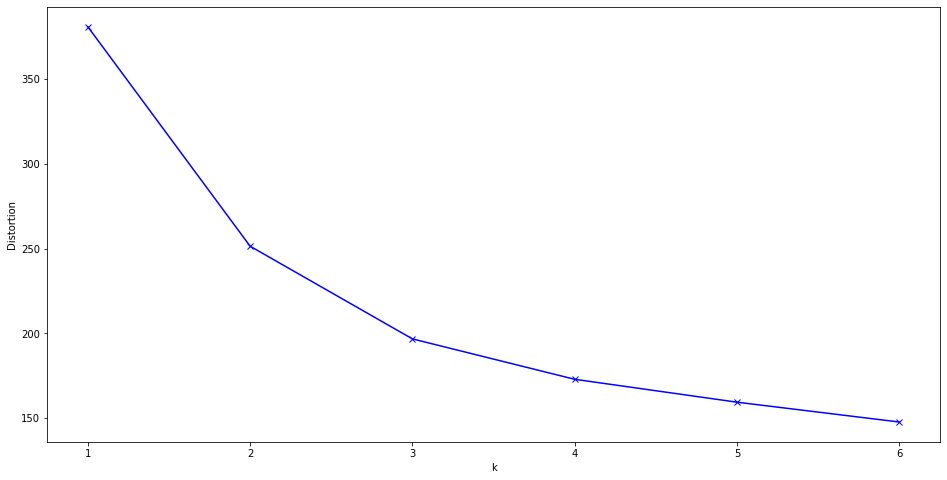

In [159]:
distortions = []
for i in range(1,7):
    kmeanModel = cluster.KMeans(n_clusters=i)
    kmeanModel.fit(X_train_MCI[['CDRSB', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'FAQ']])
    distortions.append(kmeanModel.inertia_)
    
    
    
    
    
    #clustering=cluster.KMeans(n_clusters=i)
    #clusters = clustering.fit_predict(MallData[['Spending Score (1-100)', 'Annual Income (k$)']])
    #distortions.append(clusters.inertia_)
    #MallData['Cluster'] = clusters
    #sns.scatterplot('Spending Score (1-100)', 'Annual Income (k$)', data=MallData, hue='Cluster')
    #plt.show()

plt.figure(figsize=(16,8))
plt.plot(range(1,7), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('CDRSB','MMSE','FAQ','ADAS13','RAVLT_learning',  'Ventricles', 'Entorhinal', 'Fusiform')
plt.show()

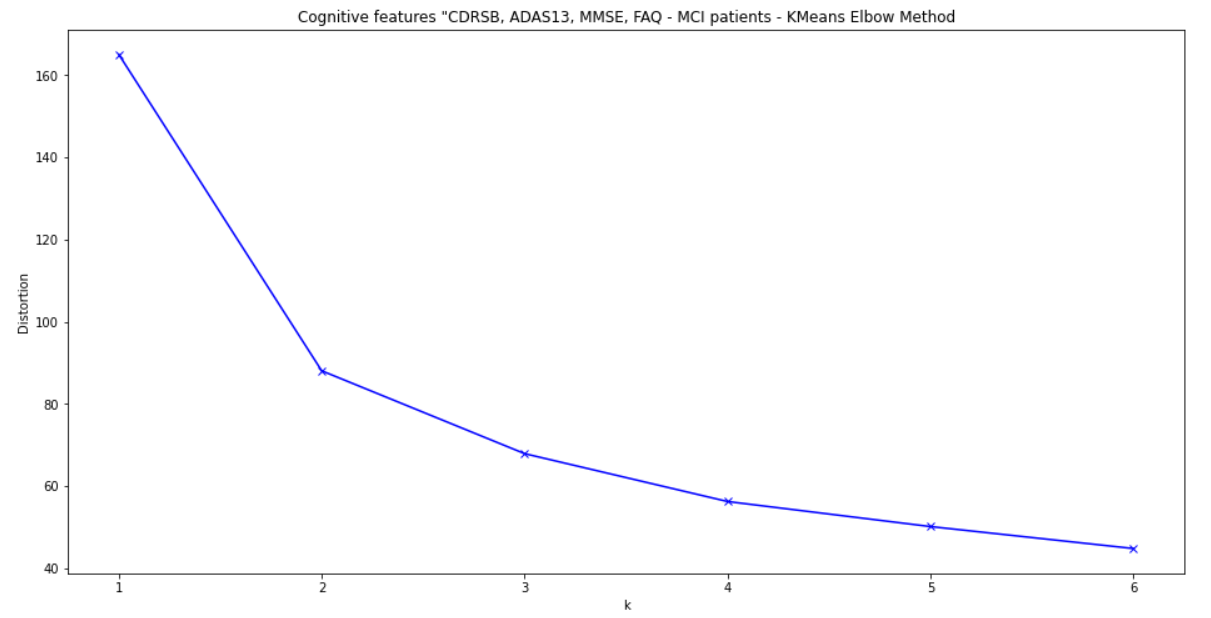

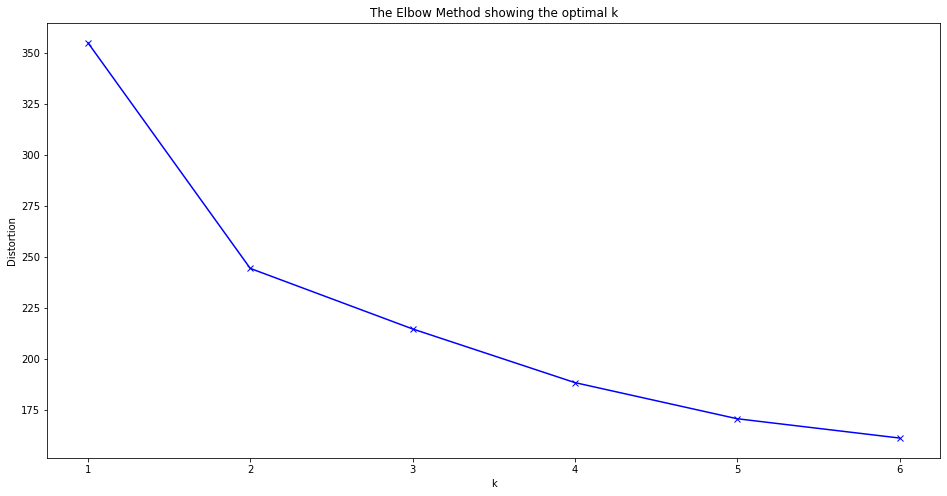

In [332]:
distortions = []
for i in range(1,7):
    kmeanModel = cluster.KMeans(n_clusters=i)
    kmeanModel.fit(X_train_AD[['RAVLT_leam','ADASI3', 'FAQ', 'ADASI3', 'Hippocampus', 'RAVLT_leam', 'Ventricles', 'Fusiform', 'WholeBrain']])
    distortions.append(kmeanModel.inertia_)
    
    
    
    
    
    #clustering=cluster.KMeans(n_clusters=i)
    #clusters = clustering.fit_predict(MallData[['Spending Score (1-100)', 'Annual Income (k$)']])
    #distortions.append(clusters.inertia_)
    #MallData['Cluster'] = clusters
    #sns.scatterplot('Spending Score (1-100)', 'Annual Income (k$)', data=MallData, hue='Cluster')
    #plt.show()

plt.figure(figsize=(16,8))
plt.plot(range(1,7), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

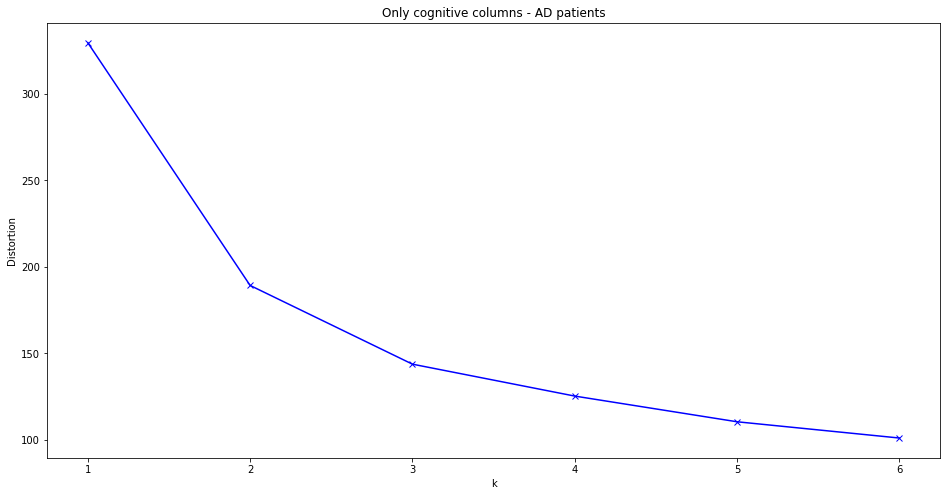

In [334]:
distortions = []
for i in range(1,7):
    kmeanModel = cluster.KMeans(n_clusters=i)
    kmeanModel.fit(X_train_AD[['CDRSB','ADASI1','ADASI3','MMSE','RAVLT_im','RAVLT_leam','RVLT_for','FAQ']])
    distortions.append(kmeanModel.inertia_)
    
    
    
    
    
    #clustering=cluster.KMeans(n_clusters=i)
    #clusters = clustering.fit_predict(MallData[['Spending Score (1-100)', 'Annual Income (k$)']])
    #distortions.append(clusters.inertia_)
    #MallData['Cluster'] = clusters
    #sns.scatterplot('Spending Score (1-100)', 'Annual Income (k$)', data=MallData, hue='Cluster')
    #plt.show()

plt.figure(figsize=(16,8))
plt.plot(range(1,7), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Only cognitive columns - AD patients')
plt.show()